
# Gas Price Forecast


**Business Overview**: You work at Trucks Inc. Your company with a marketplace business model, the company brings together Self-Employed Truck Drivers and Third Party Truck Drivers with other companies that need a truck driver to move all types of materials, such as gasoline, food (processed or not, for example, frozen meat, forzen fruits, cotton, wheat, seasonings, drinks of all types and so on) all these products are requested by companies that need a truck driver.
One side of the marketplace are companies, they all need to create an account with valid credentials and request a driver for specific locations, risk, time range to complete, intervals, priority and the company can price the trip reward or not, to all positions. of travel, Trucks Inc receives a per postage a fee.
On the other side of the marketplace are self-employed truck drivers or third-party drivers, everyone also needs to create a truck driver account and find all the trips available for them to join, after the truck driver choise the traveling, the Truck Inc make a Interview with Driver and Third Company for validate the traveling and completes the process of marketplace.

**Business Problem**: At Trucks Inc, you need to expand the marketing campaign to acquire new self-employed truck drivers, one of the hypotheses raised by the Head of Marketing was to use the price of gasoline as an incentive to attract the attention of truck drivers, as the company has a lot of trips in progress. currently open but there are around 50% of active truck drivers on the platform, so the Head of Marketing has a proposal to pay 50% of the fuel needed for the truck driver's trip if he completes a trip on the platform.
In this scenario, you need to forecast the gas price for all regions and give a statistics overview of all available regions based on gas price for for Head of Marketing decisions.


## 0.0. Requirements


### 0.1. Imports

In [ ]:
import re
import uuid
import logging

import numpy as np
import pandas as pd
import seaborn as sns

from time import sleep
from calendar import month_abbr
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from databricks import feature_store

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pyspark.sql import functions as pf

from warnings import filterwarnings
import plotly.express as px
import plotly.graph_objects as go

filterwarnings("ignore")
#from geopy.geocoders import Nominatim
#agent = Nominatim(user_agent="abc")

In [ ]:
!pip freeze

absl-py==1.0.0
adagio==0.2.4
alembic==1.13.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astor==0.8.1
asttokens==2.0.5
astunparse==1.6.3
attrs==21.4.0
azure-core==1.26.3
azure-cosmos==4.2.0
backcall==0.2.0
backports.entry-points-selectable==1.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
black==22.3.0
bleach==4.1.0
blis==0.7.9
boto3==1.21.32
botocore==1.24.32
cachetools==4.2.2
catalogue==2.0.8
category-encoders==2.5.1.post0
certifi==2021.10.8
cffi==1.15.0
chardet==4.0.0
charset-normalizer==2.0.4
click==8.0.4
cloudpickle==2.0.0
cmdstanpy==1.1.0
colorlog==6.8.2
confection==0.0.4
configparser==5.2.0
convertdate==2.4.0
coreforecast==0.0.9
cryptography==3.4.8
cycler==0.11.0
cymem==2.0.7
Cython==0.29.28
databricks-automl-runtime==0.2.15
databricks-cli==0.17.4
databricks-feature-store==0.10.1
dbl-tempo==0.1.12
dbus-python==1.2.16
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.4
diskcache==5.4.0
distlib==0.3.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
docstring-to-m


### 0.2. Aux Functions

In [ ]:
def plot_diff_acf(
    dff: pd.DataFrame,
    region: str
):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    price = dff.loc[dff["region"] == region, "price"]
    price.plot(x="date", y="price", grid=2, title=region, ax=ax[0])
    price.diff().plot(x="date", y="price", grid=2, title=region, ax=ax[2])

    plot_acf(price, lags=range(1, 50), ax=ax[1])
    plot_acf(price.diff().dropna(), lags=range(1, 50), ax=ax[3])

    for axi in ax: axi.grid(2);

    plt.tight_layout();

def describe_metrics(
    dfn: pd.DataFrame
) -> pd.DataFrame:
    metrics = pd.concat([dfn.describe().T, dfn.apply(lambda x: x.kurtosis()), dfn.apply(lambda x: x.skew())], axis=1)
    metrics.columns = metrics.columns[:-2].tolist() + ["kurtosis", "skew"]
    metrics = metrics.iloc[:, 1:]

    return metrics.style.highlight_max(color="yellow", subset=(metrics.columns[1:])).highlight_min(color="cyan").format("{:.2f}")

def plot_min_max_multiple_series(
    df: pd.DataFrame,
    mt_col: str = "month",
    yr_col: str = "year",
    y_col: str = "price"
): 
    base_cols = [mt_col, yr_col]
    y_cols = [y_col]

    df3p = df[base_cols + y_cols].groupby(base_cols).min(y_col).reset_index()
    df3pm = df[base_cols + y_cols].groupby(base_cols).max(y_col).reset_index()
    df3pb = df[base_cols + y_cols].groupby(base_cols).mean(y_col).reset_index()
    df3p = df3p.sort_values(by=[yr_col, mt_col])

    fig, ax = plt.subplots(figsize=(15,10))
    plt.xticks(
        ticks=range(1, len(df3p[mt_col].unique()) + 1), 
        labels=[month_abbr[k] for k in set(df3p[mt_col].unique())]
    )

    for variable, color in zip(df3p[yr_col].unique(), ["r", "g", "b", "y", "k"]):
        aux = df3p[df3p[yr_col] == variable]
        ax.plot(aux[mt_col], aux[y_col], label=f"Min for: {variable}", linestyle="--", color=color, marker="o")

        aux = df3pm[df3pm[yr_col] == variable]
        ax.plot(aux[mt_col], aux[y_col], label=f"Max for: {variable}", linestyle="--", color=color, marker="*")

        aux = df3pb[df3pb[yr_col] == variable]
        ax.plot(aux[mt_col], aux[y_col], label=f"Mean for: {variable}", color=color, linewidth=2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Gas Price Min/Max by Month and Year')
    ax.grid(2)

def plot_multiple_single_series(
    df: pd.DataFrame,
    x_col: str = "date",
    y_col: str = "price",
    unique_id_col: str = "region"
):
    fig, ax = plt.subplots(figsize=(14, 10))
    dfp = df[[x_col, unique_id_col, y_col]].groupby([x_col, unique_id_col]).min().reset_index()
    dfpm = df[[x_col, y_col]].groupby(x_col).mean().reset_index()

    for region in dfp[unique_id_col].unique():
        dfp[dfp[unique_id_col] == region].plot(x=x_col, y=y_col, label=region, ax=ax)

    dfpm.plot(x=x_col, y=y_col, color="k", label="mean", ax=ax, linestyle="--")

    ax.grid(1)
    ax.set_title("Min Price over Weeks & Region");
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

def plot_seasons_year_month(
    df3: pd.DataFrame,
    m_col: str = "month",
    yr_col: str = "year",
    y: str = "price"
):
    df3p = df3[[m_col, yr_col, y]].groupby([yr_col, m_col]).sum(y).reset_index()
    df3p = df3p.sort_values(by=[yr_col, m_col])

    fig, ax = plt.subplots(figsize=(15,10))
    plt.xticks(
        ticks=range(1, len(df3p[m_col].unique()) + 1), 
        labels=[month_abbr[k] for k in set(df3p[m_col].unique())]
    )

    for variable in df3p[yr_col].unique():
        aux = df3p[df3p[yr_col] == variable]
        ax.plot(aux[m_col], aux[y], label=variable)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title('Gas Price by Month and Year')
    ax.grid(2)

def plot_seasons_quarter_month(
    df3 = pd.DataFrame,
    yr_col: str = "year",
    q_col: str = "quarter",
    y: str = "price"
):
    fig, ax = plt.subplots(2, 2, figsize=(10,6))
    ax = ax.flatten()

    df3p = df3[[y, yr_col, q_col]].groupby([yr_col, q_col]).sum(y).reset_index()
    df3p = df3p.sort_values(by=[yr_col, q_col])

    for i, q in enumerate(df3p[q_col].unique()):
        axis = df3p.loc[df3p[q_col] == q, [y, q_col, yr_col]].plot(
            kind="line", x=yr_col, y=y, 
            label= f'Q{q}', ax=ax[i], color="k", grid=2
        )
        axis = axis.get_children()[0]
        
        ax[i].hlines(
            y=np.mean(axis.get_ydata()), 
            xmin=axis.get_xdata()[0], 
            xmax=axis.get_xdata()[-1],
            color='b'
        )
        
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation=45)

    plt.tight_layout()


### 0.3. Load Data

In [ ]:
df = spark.read.format("delta").load(f"s3://{silver_bucket_name}/gas")

# If append and partitioned by data_base on silver too 
df = df.filter(pf.col("data_base") == df.select(pf.max(pf.col("data_base"))).collect()[0][0])

df = df.toPandas()
df.drop(columns=["data_base"], axis=1, inplace=True)

In [ ]:
df.head()

us 
 east_coast 
 new_england 
 central_atlantic 
 lower_atlantic 
 midwest 
 gulf_coast 
 rocky_mountain 
 west_coast 
 california 
 colorado 
 florida 
 massachusetts 
 minnesota 
 new_york 
 ohio 
 texas 
 washington 
 boston_ma 
 chicago 
 cleveland_oh 
 denver 
 houston 
 los_angeles 
 miami_fl 
 new_york_city 
 san_francisco 
 seattle_wa 
 date 
 
 
 
 
 0 
 1.068 
 1.040 
 1.068 
 1.068 
 1.023 
 1.061 
 1.064 
 1.093 
 1.152 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-05 
 
 
 1 
 1.079 
 1.047 
 1.073 
 1.072 
 1.032 
 1.077 
 1.071 
 1.118 
 1.154 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-12 
 
 
 2 
 1.079 
 1.054 
 1.074 
 1.077 
 1.040 
 1.067 
 1.081 
 1.120 
 1.155 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-19 
 
 
 3 
 1.086 
 1.059 
 1.076 
 1.080 
 1.046 
 1.078 
 1.081 
 1.169 
 1.157 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-04-26 
 
 
 4 
 1.086 
 1.062 
 1.080 
 1.084 
 1.050 
 1.073 
 1.084 
 1.161 
 1.161 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1993-05-03


## 1.0. Descriptive Statistics

In [ ]:
df1 = df.copy()


### 1.1. Dataset Dimension

In [ ]:
print(f"Number of Cols: {df1.shape[1]}")
print(f"Number of Rows: {df1.shape[0]}")

Number of Cols: 29
Number of Rows: 1624



### 1.2. Check Dtypes

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   us                1624 non-null   float64       
 1   east_coast        1624 non-null   float64       
 2   new_england       1624 non-null   float64       
 3   central_atlantic  1624 non-null   float64       
 4   lower_atlantic    1624 non-null   float64       
 5   midwest           1624 non-null   float64       
 6   gulf_coast        1624 non-null   float64       
 7   rocky_mountain    1624 non-null   float64       
 8   west_coast        1624 non-null   float64       
 9   california        1252 non-null   float64       
 10  colorado          1250 non-null   float64       
 11  florida           1095 non-null   float64       
 12  massachusetts     1095 non-null   float64       
 13  minnesota         1250 non-null   float64       
 14  new_york          1250 n


### 1.3. Check Missing Values


Missing values because do not have a complete history to all regions of US. 

In [ ]:
df1.isna().sum() / len(df)

Out[8]: us                  0.000000
east_coast          0.000000
new_england         0.000000
central_atlantic    0.000000
lower_atlantic      0.000000
midwest             0.000000
gulf_coast          0.000000
rocky_mountain      0.000000
west_coast          0.000000
california          0.229064
colorado            0.230296
florida             0.325739
massachusetts       0.325739
minnesota           0.230296
new_york            0.230296
ohio                0.325739
texas               0.230296
washington          0.325739
boston_ma           0.325739
chicago             0.230296
cleveland_oh        0.325739
denver              0.230296
houston             0.230296
los_angeles         0.230296
miami_fl            0.326355
new_york_city       0.230296
san_francisco       0.230296
seattle_wa          0.325739
date                0.000000
dtype: float64


### 1.4. Descriptive Statistics


#### 1.4.1. Numerical Attributes

In [ ]:
dfn = df1.drop(columns=["date"], axis=1)

In [ ]:
# 1993 up to 2024
df1.date.min(), df1.date.max()

Out[10]: (Timestamp('1993-04-05 00:00:00'), Timestamp('2024-05-13 00:00:00'))

In [ ]:
describe_metrics(dfn=dfn)

count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 kurtosis 
 skew 
 
 
 
 
 us 
 1624.00 
 2.36 
 0.95 
 0.95 
 1.44 
 2.37 
 3.09 
 5.11 
 -1.07 
 0.20 
 
 
 east_coast 
 1624.00 
 2.34 
 0.94 
 0.94 
 1.42 
 2.37 
 3.08 
 4.94 
 -1.12 
 0.18 
 
 
 new_england 
 1624.00 
 2.39 
 0.95 
 0.99 
 1.48 
 2.39 
 3.12 
 5.11 
 -1.03 
 0.24 
 
 
 central_atlantic 
 1624.00 
 2.41 
 0.96 
 0.98 
 1.47 
 2.46 
 3.14 
 5.08 
 -1.10 
 0.17 
 
 
 lower_atlantic 
 1624.00 
 2.28 
 0.92 
 0.91 
 1.37 
 2.32 
 3.01 
 4.80 
 -1.13 
 0.18 
 
 
 midwest 
 1624.00 
 2.28 
 0.92 
 0.89 
 1.40 
 2.28 
 3.00 
 5.04 
 -1.03 
 0.24 
 
 
 gulf_coast 
 1624.00 
 2.19 
 0.86 
 0.92 
 1.36 
 2.18 
 2.89 
 4.71 
 -1.02 
 0.28 
 
 
 rocky_mountain 
 1624.00 
 2.36 
 0.94 
 0.99 
 1.45 
 2.36 
 3.06 
 5.12 
 -1.00 
 0.26 
 
 
 west_coast 
 1624.00 
 2.69 
 1.13 
 1.10 
 1.57 
 2.80 
 3.54 
 5.98 
 -0.80 
 0.28 
 
 
 california 
 1252.00 
 3.23 
 1.02 
 1.15 
 2.53 
 3.19 
 3.90 
 6.36 
 -0.11 
 0.27 
 
 
 colorado 
 1250.00 
 2.66 
 0.78 
 1.08 
 2.10 
 2.64 
 3.25 
 5.00 
 -0.68 
 0.12 
 
 
 florida 
 1095.00 
 2.83 
 0.65 
 1.49 
 2.33 
 2.77 
 3.40 
 4.94 
 -0.60 
 0.19 
 
 
 massachusetts 
 1095.00 
 2.87 
 0.69 
 1.52 
 2.34 
 2.77 
 3.49 
 5.15 
 -0.48 
 0.27 
 
 
 minnesota 
 1250.00 
 2.59 
 0.76 
 1.01 
 2.02 
 2.57 
 3.20 
 4.80 
 -0.77 
 0.13 
 
 
 new_york 
 1250.00 
 2.85 
 0.80 
 1.22 
 2.26 
 2.84 
 3.52 
 5.03 
 -0.78 
 0.04 
 
 
 ohio 
 1095.00 
 2.78 
 0.68 
 1.40 
 2.26 
 2.73 
 3.34 
 5.10 
 -0.56 
 0.21 
 
 
 texas 
 1250.00 
 2.50 
 0.74 
 1.04 
 1.94 
 2.49 
 3.07 
 4.72 
 -0.74 
 0.14 
 
 
 washington 
 1095.00 
 3.19 
 0.78 
 1.54 
 2.69 
 3.10 
 3.79 
 5.50 
 -0.11 
 0.31 
 
 
 boston_ma 
 1095.00 
 2.88 
 0.69 
 1.53 
 2.33 
 2.77 
 3.49 
 5.18 
 -0.43 
 0.29 
 
 
 chicago 
 1250.00 
 2.87 
 0.89 
 1.12 
 2.24 
 2.84 
 3.54 
 5.93 
 -0.43 
 0.22 
 
 
 cleveland_oh 
 1095.00 
 2.80 
 0.68 
 1.41 
 2.28 
 2.75 
 3.36 
 5.11 
 -0.54 
 0.22 
 
 
 denver 
 1250.00 
 2.65 
 0.78 
 1.06 
 2.10 
 2.63 
 3.23 
 4.99 
 -0.68 
 0.13 
 
 
 houston 
 1250.00 
 2.49 
 0.74 
 1.01 
 1.93 
 2.49 
 3.05 
 4.72 
 -0.71 
 0.16 
 
 
 los_angeles 
 1250.00 
 3.25 
 1.03 
 1.01 
 2.55 
 3.19 
 3.94 
 6.33 
 -0.15 
 0.19 
 
 
 miami_fl 
 1094.00 
 2.96 
 0.66 
 1.56 
 2.50 
 2.90 
 3.53 
 4.99 
 -0.55 
 0.13 
 
 
 new_york_city 
 1250.00 
 2.77 
 0.79 
 1.18 
 2.21 
 2.75 
 3.45 
 5.11 
 -0.73 
 0.09 
 
 
 san_francisco 
 1250.00 
 3.29 
 1.01 
 1.28 
 2.56 
 3.27 
 3.94 
 6.50 
 -0.05 
 0.34 
 
 
 seattle_wa 
 1095.00 
 3.24 
 0.82 
 1.51 
 2.73 
 3.13 
 3.82 
 5.64 
 -0.04 
 0.34

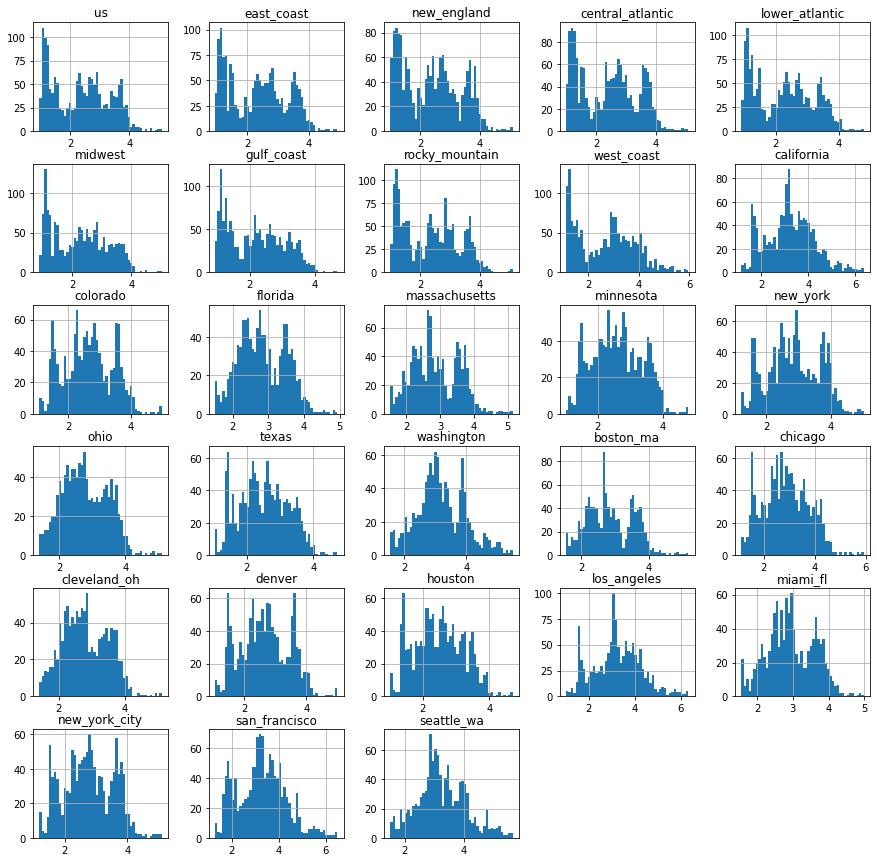

In [ ]:
dfn.hist(
    bins=50,
    figsize=(15,15)
);

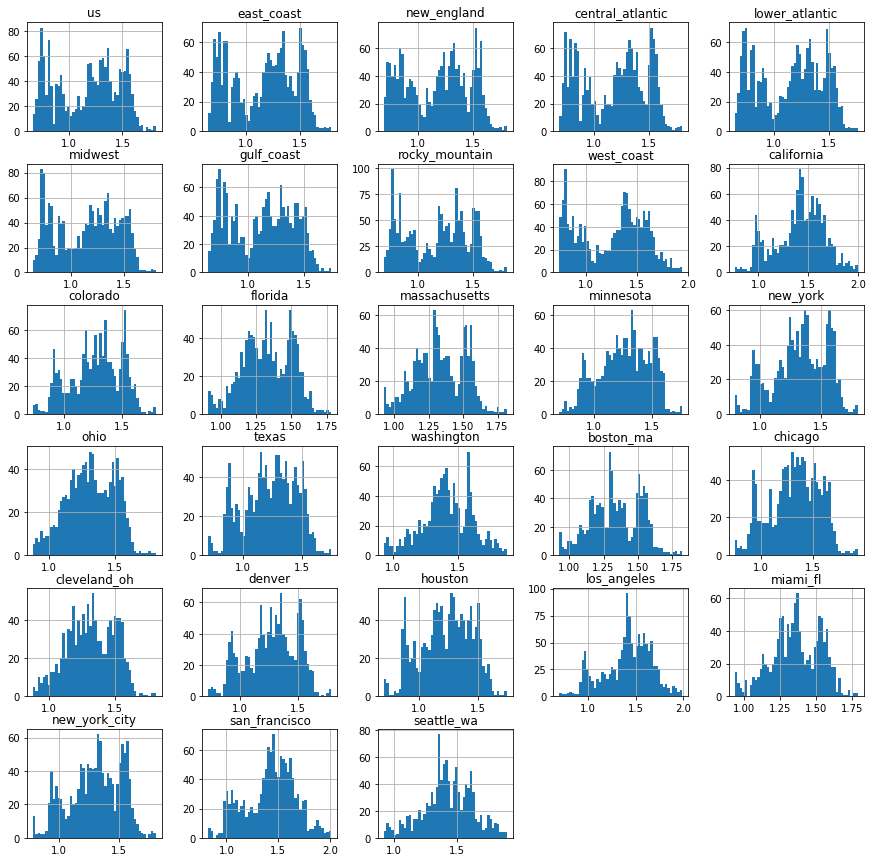

In [ ]:
np.log1p(dfn).hist(
    bins=50,
    figsize=(15,15)
);


Is possible to see 0 sales on regions where data is never collected, is just old data maybe i will filter this sales in future or is possible to apply weigth column to this old examples such as SES foecasting, and the lower weight indicate older rows in dataset, is possible to do simple two approaches for this missing values.

The log transformation for target sales for more symmetric histograms and is possible to see very good histograms in some regions, probably the price change for lat long or regions.

I have data from 1993-04-05 to 2024-05-06 in a weekly pattern and 1623 rows of raw data.

Old data is probably not as relevant as new data (maybe 100% irrelevant, just for visual plots to see time series features), especially with the objective of predicting the price of gasoline, only for 2010 to 2024 many "things" have changed, the economy, politics, exports and other infinite variables that can lead to changes in the price of gas.


## 2.0. Time Series Analysis

In [ ]:
df2 = df1.copy()


### 2.1. Dataset Preprocessing


#### 2.1.1. Fillout Missing Values


Fillout with 0, because in this dates, the region "not selling gas", but is quite dangerous to fillout with zeros because is possible to lose some patterns and change descriptive statistics with a lot of zeros. The correct in some cases is a backcasting for this type of inconsistent series or just filtering the series util a cutoff date more recent (or maybe the region do not have selling any gas util a certain date, but is not possible this assumption).

In [ ]:
df2.fillna(0, inplace=True)


A lot of metrics changed very drastically, i just fillout with outliers or a lot of influent points that changed the distribution (negative kurtosis) and other position metrics such as 25%, is a good idea to fillout this old data and check again the descriptive statistics for find more patterns.

In [ ]:
describe_metrics(df2.drop(columns=["date"], axis=1))

mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 kurtosis 
 skew 
 
 
 
 
 us 
 2.36 
 0.95 
 0.95 
 1.44 
 2.37 
 3.09 
 5.11 
 -1.07 
 0.20 
 
 
 east_coast 
 2.34 
 0.94 
 0.94 
 1.42 
 2.37 
 3.08 
 4.94 
 -1.12 
 0.18 
 
 
 new_england 
 2.39 
 0.95 
 0.99 
 1.48 
 2.39 
 3.12 
 5.11 
 -1.03 
 0.24 
 
 
 central_atlantic 
 2.41 
 0.96 
 0.98 
 1.47 
 2.46 
 3.14 
 5.08 
 -1.10 
 0.17 
 
 
 lower_atlantic 
 2.28 
 0.92 
 0.91 
 1.37 
 2.32 
 3.01 
 4.80 
 -1.13 
 0.18 
 
 
 midwest 
 2.28 
 0.92 
 0.89 
 1.40 
 2.28 
 3.00 
 5.04 
 -1.03 
 0.24 
 
 
 gulf_coast 
 2.19 
 0.86 
 0.92 
 1.36 
 2.18 
 2.89 
 4.71 
 -1.02 
 0.28 
 
 
 rocky_mountain 
 2.36 
 0.94 
 0.99 
 1.45 
 2.36 
 3.06 
 5.12 
 -1.00 
 0.26 
 
 
 west_coast 
 2.69 
 1.13 
 1.10 
 1.57 
 2.80 
 3.54 
 5.98 
 -0.80 
 0.28 
 
 
 california 
 2.49 
 1.63 
 0.00 
 1.60 
 2.91 
 3.68 
 6.36 
 -0.89 
 -0.29 
 
 
 colorado 
 2.05 
 1.31 
 0.00 
 1.41 
 2.31 
 3.00 
 5.00 
 -0.98 
 -0.40 
 
 
 florida 
 1.91 
 1.43 
 0.00 
 0.00 
 2.34 
 3.03 
 4.94 
 -1.40 
 -0.31 
 
 
 massachusetts 
 1.94 
 1.46 
 0.00 
 0.00 
 2.36 
 3.07 
 5.15 
 -1.38 
 -0.28 
 
 
 minnesota 
 2.00 
 1.28 
 0.00 
 1.35 
 2.24 
 2.96 
 4.80 
 -0.99 
 -0.39 
 
 
 new_york 
 2.19 
 1.39 
 0.00 
 1.53 
 2.51 
 3.24 
 5.03 
 -0.99 
 -0.45 
 
 
 ohio 
 1.87 
 1.42 
 0.00 
 0.00 
 2.27 
 2.99 
 5.10 
 -1.39 
 -0.27 
 
 
 texas 
 1.92 
 1.23 
 0.00 
 1.33 
 2.16 
 2.87 
 4.72 
 -0.99 
 -0.39 
 
 
 washington 
 2.15 
 1.63 
 0.00 
 0.00 
 2.71 
 3.37 
 5.50 
 -1.35 
 -0.26 
 
 
 boston_ma 
 1.94 
 1.46 
 0.00 
 0.00 
 2.36 
 3.06 
 5.18 
 -1.37 
 -0.27 
 
 
 chicago 
 2.21 
 1.44 
 0.00 
 1.42 
 2.48 
 3.27 
 5.93 
 -0.95 
 -0.32 
 
 
 cleveland_oh 
 1.89 
 1.43 
 0.00 
 0.00 
 2.29 
 3.01 
 5.11 
 -1.39 
 -0.27 
 
 
 denver 
 2.04 
 1.31 
 0.00 
 1.40 
 2.30 
 2.99 
 4.99 
 -0.98 
 -0.40 
 
 
 houston 
 1.92 
 1.23 
 0.00 
 1.34 
 2.15 
 2.86 
 4.72 
 -0.98 
 -0.38 
 
 
 los_angeles 
 2.50 
 1.64 
 0.00 
 1.53 
 2.95 
 3.71 
 6.33 
 -0.93 
 -0.30 
 
 
 miami_fl 
 1.99 
 1.49 
 0.00 
 0.00 
 2.50 
 3.12 
 4.99 
 -1.42 
 -0.34 
 
 
 new_york_city 
 2.13 
 1.35 
 0.00 
 1.48 
 2.43 
 3.16 
 5.11 
 -0.98 
 -0.44 
 
 
 san_francisco 
 2.53 
 1.65 
 0.00 
 1.68 
 2.95 
 3.73 
 6.50 
 -0.86 
 -0.30 
 
 
 seattle_wa 
 2.19 
 1.66 
 0.00 
 0.00 
 2.76 
 3.45 
 5.64 
 -1.33 
 -0.23


#### 2.1.2. Stacking Dataframe

In [ ]:
df2_long = df2.melt(
    id_vars=["date"],
    var_name="region",
    value_name="price"
)

df2_long.columns = ["date", "region", "price"]


Long dataframe for machine learning.

The date columns, id of time series and the target variable, classic design of a table in time series.

In [ ]:
df2_long.head()

date 
 region 
 price 
 
 
 
 
 0 
 1993-04-05 
 us 
 1.068 
 
 
 1 
 1993-04-12 
 us 
 1.079 
 
 
 2 
 1993-04-19 
 us 
 1.079 
 
 
 3 
 1993-04-26 
 us 
 1.086 
 
 
 4 
 1993-05-03 
 us 
 1.086


### 2.2. Time Plots

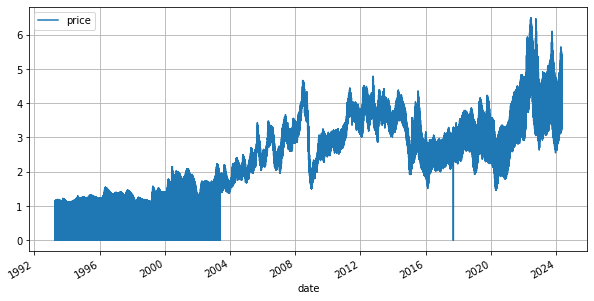

In [ ]:
df2_long.plot(
    x="date",
    y="price",
    figsize=(10,5),
    grid=2
);


### 2.3. Statistical Checkout


I will apply some resume of data to check the variability of patterns, such as acf and diff.

Is possible to apply some other metrics, such as:

1. Coefficient of Hurst: Hurst coefficient of a time series which is a measure of “long memory”. A series with long memory will have significant autocorrelations for many lags.
2. Feature Spectral: Compute the (Shannon) spectral entropy of a time series, which is a measure of how easy the series is to forecast. A series which has strong trend and seasonality (and so is easy to forecast) will have entropy close to 0. A series that is very noisy (and so is difficult to forecast) will have entropy close to 1.
3. Box Pierce, Ljung & KPSS: Compute the testing of time series is white noise (stationary) or not (visually i will see the series is not stationary, filtering years of data the series is not stationary too).
4. Tiled Features: Gives the variances, mean, and other statistics of "pieces" of data over time.
5. Guerrero: Better lambda for Box Cox transformation. 

I selected some metrics to see between all data and >= 2019.

1. Mean Differences Squares: Is very basic, if i see a very big difference, the series change drastically. 
2. Mean Shift for 12 weeks: Shifting the series in 12 lags to see any pattern in 12 likes shift.
3. Mean Shift for 52 weeks: Shifting the series in 52 lags to see any pattern in 52 likes shift.
4. Mean Autocorrelation of n Lag: Mean of first autocorrelation in lag 1, this measures the average correlation between each observation in the time series and the observation in the previous time period (lag n).
  - A high autocorrelation at lag 1 suggests that consecutive observations are strongly related to each other, indicating persistence or trend in the data.
  - A high autocorrelated at lag 51, 52, 53 suggests that consecutive observation are strongly related to same observation one year ago (weekly data).

In [ ]:
dff = df2_long[df2_long["date"] >= "2020-01-01"].reset_index(drop=True)

In [ ]:
dff.groupby("region").agg(
    m_o_price=("price", lambda x: np.mean(x)),
    std_o_price=("price", lambda x: np.std(x)),

    m_diff=("price", lambda x: np.mean(x.diff() ** 2)),
    m12_shift=("price", lambda x: np.mean(x.shift(12))),
    m52_shift=("price", lambda x: np.mean(x.shift(52))),

    acf1=("price", lambda x: acf(x, nlags=1)[-1]),
    acf26=("price", lambda x: acf(x, nlags=26)[-1]),
    acf51=("price", lambda x: acf(x, nlags=51)[-1]),
    acf52=("price", lambda x: acf(x, nlags=52)[-1]),
    acf53=("price", lambda x: acf(x, nlags=53)[-1]),

    acf51_sq=("price", lambda x: np.sum(acf(x, nlags=51)[1:] ** 2)),
    acf52_sq=("price", lambda x: np.sum(acf(x, nlags=52)[1:] ** 2)),
    acf53_sq=("price", lambda x: np.sum(acf(x, nlags=53)[1:] ** 2)),

    diff1_acf1=("price", lambda x: acf(x.diff().dropna(), nlags=1)[-1]),
    diff1_acf52=("price", lambda x: np.sum(acf(x.diff().dropna(), nlags=52)[1:] ** 2)),
    
    diff2_acf1=("price", lambda x: acf(x.diff().dropna().diff().dropna(), nlags=1)[-1]),
    diff2_acf52=("price", lambda x: np.sum(acf(x.diff().dropna().diff().dropna(), nlags=52)[1:] ** 2)),
).sort_values("m_o_price", ascending=True)

m_o_price 
 std_o_price 
 m_diff 
 m12_shift 
 m52_shift 
 acf1 
 acf26 
 acf51 
 acf52 
 acf53 
 acf51_sq 
 acf52_sq 
 acf53_sq 
 diff1_acf1 
 diff1_acf52 
 diff2_acf1 
 diff2_acf52 
 
 
 region 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 houston 
 2.845557 
 0.673134 
 0.006505 
 2.827019 
 2.770517 
 0.990628 
 0.426686 
 0.147463 
 0.138112 
 0.127805 
 15.622745 
 15.641820 
 15.658154 
 0.458377 
 0.642368 
 -0.320473 
 0.330845 
 
 
 texas 
 2.850575 
 0.679203 
 0.008176 
 2.831125 
 2.771847 
 0.989036 
 0.431936 
 0.157740 
 0.148189 
 0.137170 
 15.741817 
 15.763777 
 15.782592 
 0.278720 
 0.420070 
 -0.487261 
 0.535672 
 
 
 gulf_coast 
 2.881311 
 0.676971 
 0.006824 
 2.863398 
 2.805472 
 0.990528 
 0.455496 
 0.151639 
 0.141020 
 0.129405 
 16.431101 
 16.450988 
 16.467734 
 0.385604 
 0.524350 
 -0.394573 
 0.443057 
 
 
 lower_atlantic 
 3.055118 
 0.668132 
 0.005985 
 3.033963 
 2.968557 
 0.991142 
 0.494146 
 0.162144 
 0.150488 
 0.138629 
 17.644446 
 17.667093 
 17.686311 
 0.449433 
 0.505550 
 -0.253162 
 0.327785 
 
 
 minnesota 
 3.055882 
 0.711755 
 0.006276 
 3.042833 
 2.965199 
 0.991819 
 0.497338 
 0.205646 
 0.193778 
 0.182042 
 17.907176 
 17.944726 
 17.977865 
 0.522324 
 0.746256 
 -0.228882 
 0.233822 
 
 
 ohio 
 3.084355 
 0.710917 
 0.018649 
 3.062185 
 3.004517 
 0.979226 
 0.478994 
 0.195152 
 0.182118 
 0.165266 
 16.597267 
 16.630434 
 16.657747 
 0.041982 
 0.251385 
 -0.509566 
 0.551310 
 
 
 midwest 
 3.100513 
 0.718658 
 0.007231 
 3.081431 
 3.016614 
 0.990725 
 0.472702 
 0.192891 
 0.180668 
 0.167539 
 17.015608 
 17.048249 
 17.076318 
 0.530605 
 0.804043 
 -0.236615 
 0.276175 
 
 
 florida 
 3.114768 
 0.678507 
 0.009770 
 3.093139 
 3.026830 
 0.987445 
 0.489356 
 0.164715 
 0.153492 
 0.141611 
 17.244915 
 17.268475 
 17.288528 
 0.122010 
 0.197267 
 -0.451646 
 0.462147 
 
 
 cleveland_oh 
 3.123316 
 0.705608 
 0.016001 
 3.101824 
 3.049278 
 0.981781 
 0.488617 
 0.174707 
 0.161985 
 0.147288 
 16.670905 
 16.697144 
 16.718838 
 0.111615 
 0.300788 
 -0.516680 
 0.547208 
 
 
 east_coast 
 3.176421 
 0.683862 
 0.004962 
 3.158227 
 3.088392 
 0.992400 
 0.516830 
 0.162021 
 0.150457 
 0.138651 
 18.451748 
 18.474386 
 18.493610 
 0.521758 
 0.605118 
 -0.193682 
 0.339847 
 
 
 miami_fl 
 3.188338 
 0.689893 
 0.007541 
 3.166449 
 3.094330 
 0.990045 
 0.501102 
 0.171795 
 0.159961 
 0.147694 
 17.803731 
 17.829318 
 17.851132 
 0.228734 
 0.264583 
 -0.416323 
 0.387745 
 
 
 new_england 
 3.246145 
 0.730879 
 0.005157 
 3.232046 
 3.152307 
 0.992828 
 0.526489 
 0.158953 
 0.147877 
 0.136296 
 18.681639 
 18.703507 
 18.722083 
 0.553092 
 0.722804 
 -0.240502 
 0.347484 
 
 
 massachusetts 
 3.249386 
 0.737086 
 0.005162 
 3.235620 
 3.154261 
 0.992998 
 0.528628 
 0.155569 
 0.144849 
 0.133544 
 18.804196 
 18.825177 
 18.843011 
 0.528572 
 0.717914 
 -0.228965 
 0.449012 
 
 
 denver 
 3.255737 
 0.704773 
 0.010226 
 3.261241 
 3.217233 
 0.988532 
 0.357568 
 0.172829 
 0.161232 
 0.148799 
 13.068306 
 13.094302 
 13.116443 
 0.515988 
 1.108190 
 -0.320980 
 0.470771 
 
 
 colorado 
 3.266899 
 0.703231 
 0.009505 
 3.272264 
 3.226352 
 0.989319 
 0.379291 
 0.168009 
 0.156344 
 0.143903 
 13.676913 
 13.701356 
 13.722065 
 0.509303 
 1.122810 
 -0.356913 
 0.498253 
 
 
 boston_ma 
 3.269978 
 0.746271 
 0.004969 
 3.256620 
 3.173483 
 0.993179 
 0.528628 
 0.156534 
 0.145967 
 0.134751 
 18.882675 
 18.903981 
 18.922139 
 0.538045 
 0.743250 
 -0.239263 
 0.399316 
 
 
 us 
 3.282088 
 0.719380 
 0.005156 
 3.262134 
 3.186966 
 0.992573 
 0.509417 
 0.185143 
 0.172153 
 0.158424 
 18.245450 
 18.275087 
 18.300185 
 0.604985 
 0.896380 
 -0.151720 
 0.289324 
 
 
 new_york_city 
 3.282583 
 0.707243 
 0.005751 
 3.268731 
 3.194727 
 0.991875 
 0.515788 
 0.148851 
 0.137769 
 0.126228 
 18.227289 
 18.246270 
 18.262203 
 0.498420 
 0.601454 
 -0.236478 
 0.345664 
 
 
 new_york 
 3.311860 
 0.707652 
 0.004745

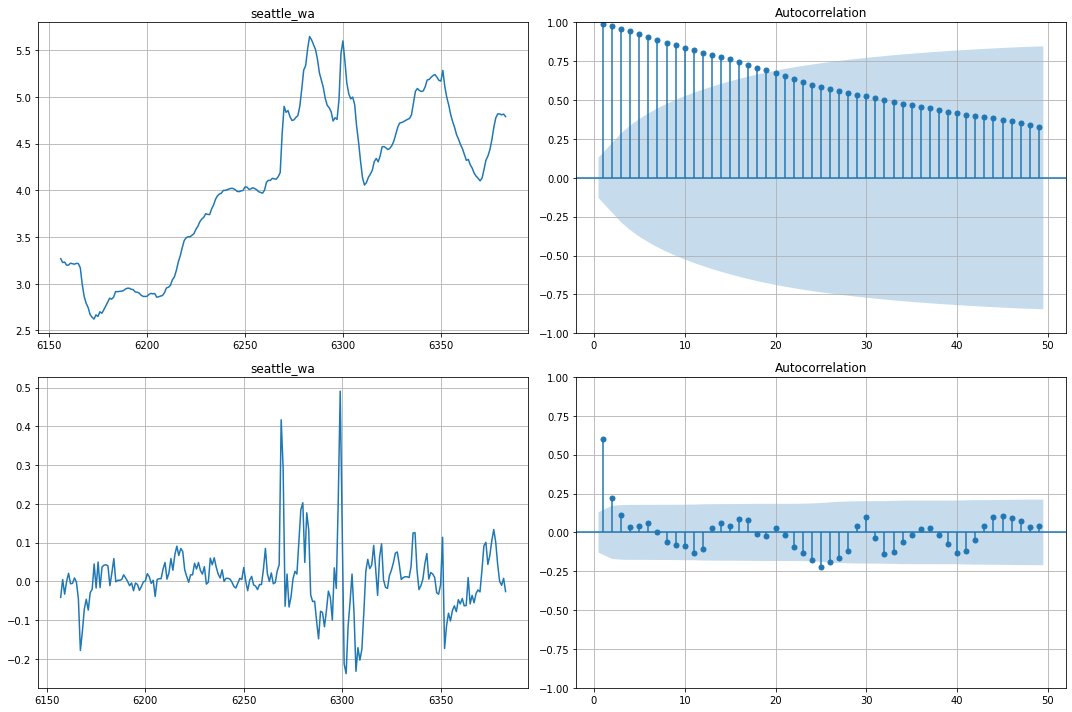

In [ ]:
plot_diff_acf(dff, "seattle_wa")

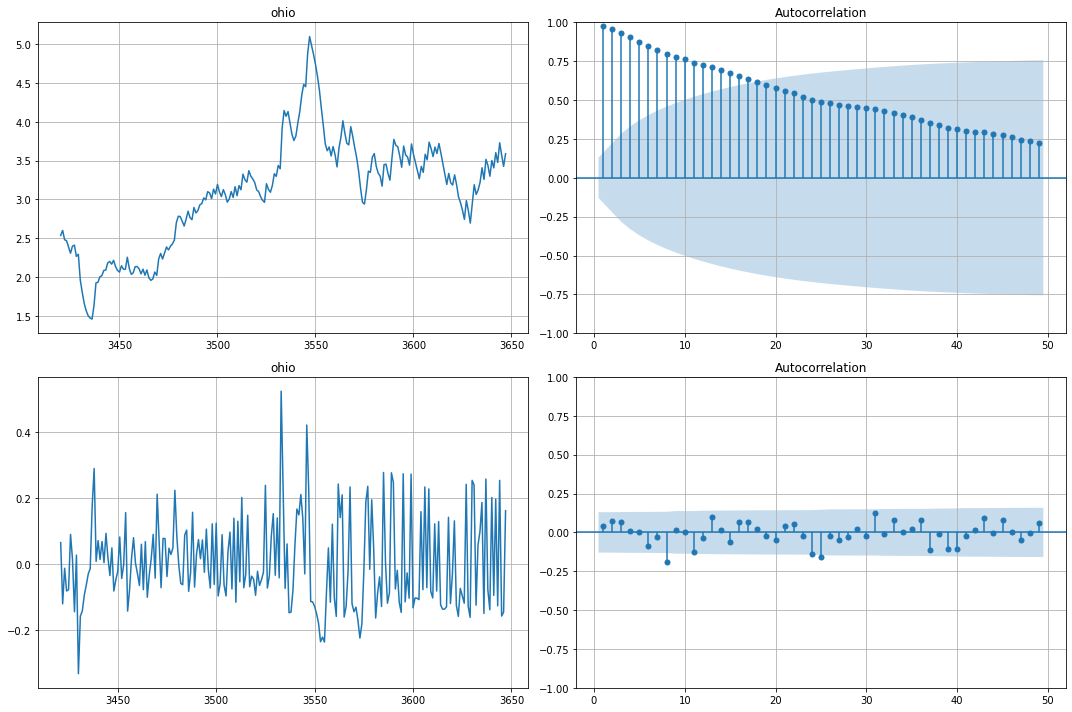

In [ ]:
plot_diff_acf(dff, "ohio")

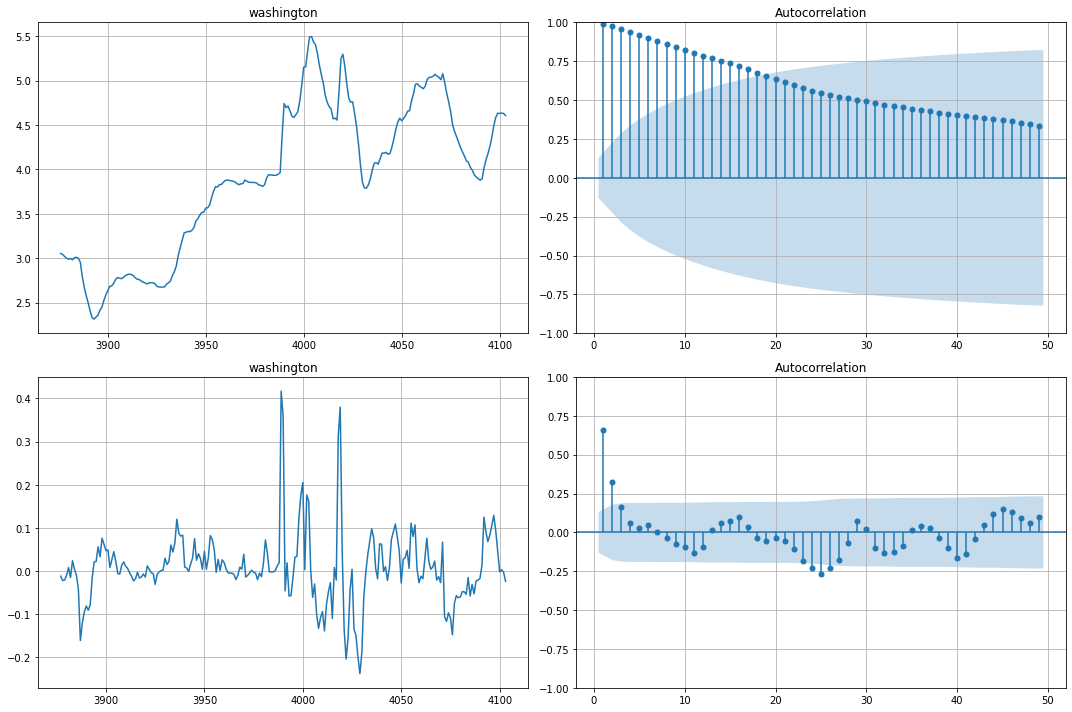

In [ ]:
plot_diff_acf(dff, "washington")

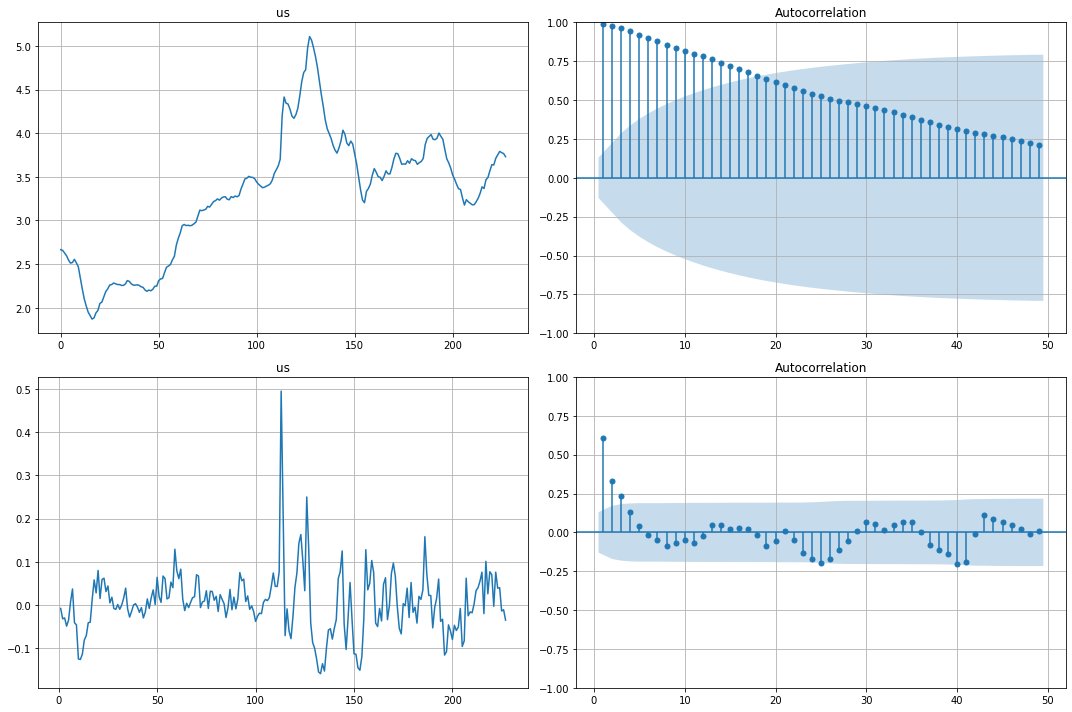

In [ ]:
plot_diff_acf(dff, "us")

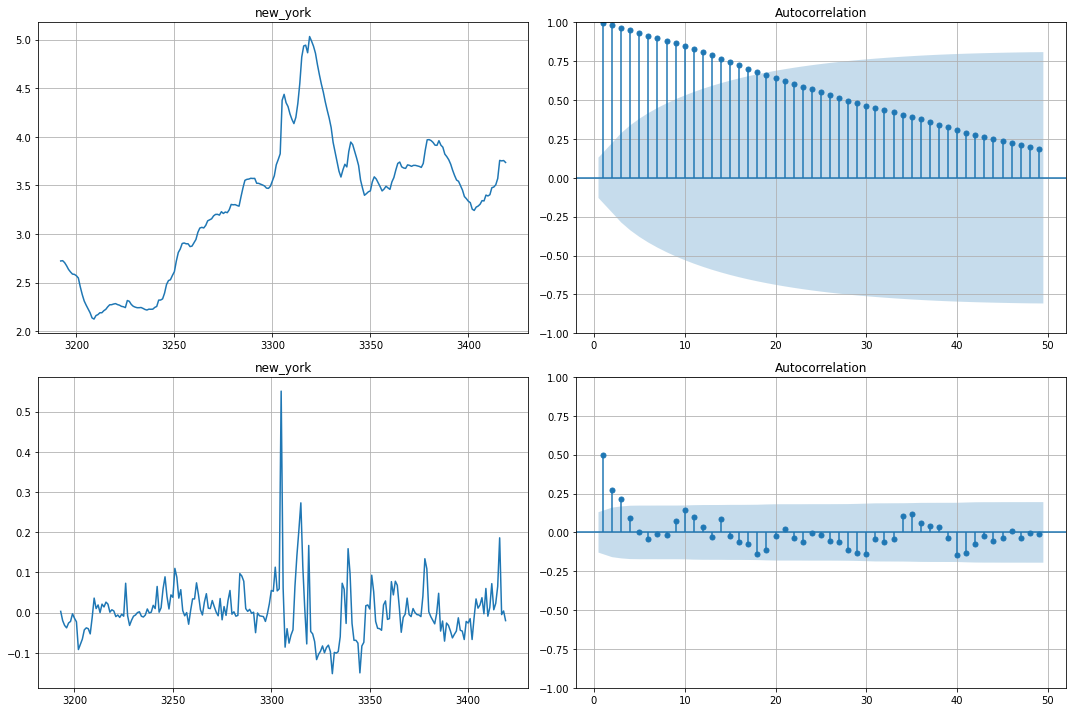

In [ ]:
plot_diff_acf(dff, "new_york")

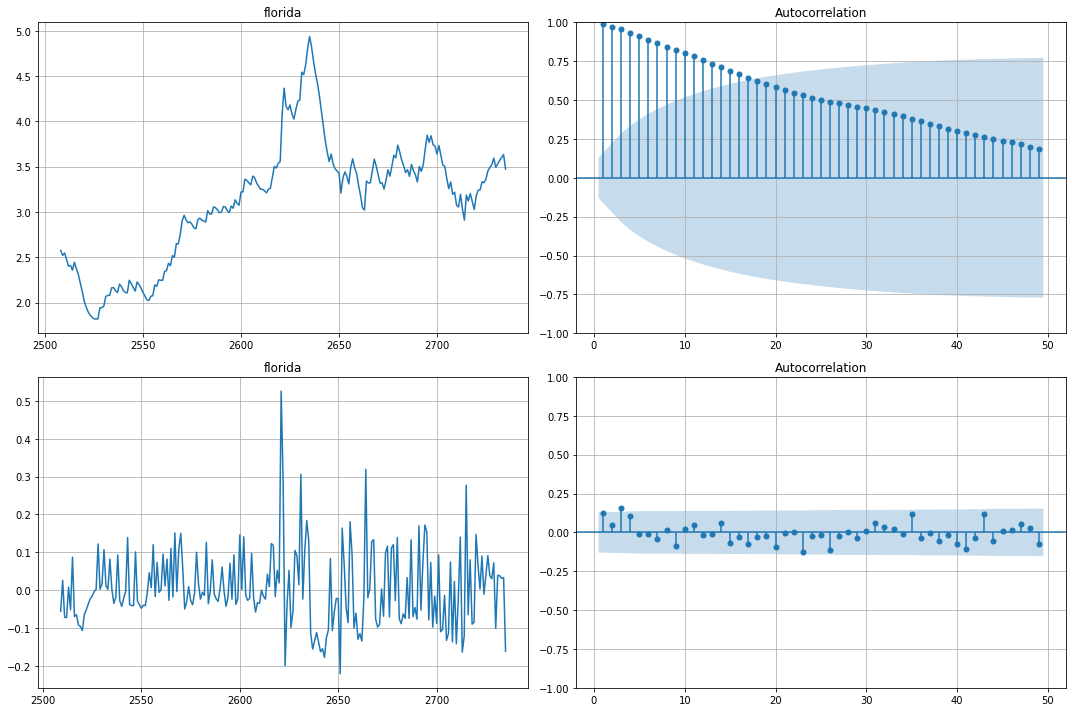

In [ ]:
plot_diff_acf(dff, "florida")

In [ ]:
dfn = dff.pivot(columns="region", values="price", index="date")

describe_metrics(dfn=dfn)

mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 kurtosis 
 skew 
 
 
 region 
   
   
   
   
   
   
   
   
   
 
 
 
 
 boston_ma 
 3.27 
 0.75 
 2.00 
 2.64 
 3.42 
 3.69 
 5.18 
 -0.39 
 0.11 
 
 
 california 
 4.42 
 0.93 
 2.72 
 3.49 
 4.56 
 5.03 
 6.36 
 -0.83 
 -0.04 
 
 
 central_atlantic 
 3.34 
 0.70 
 2.06 
 2.73 
 3.50 
 3.73 
 5.08 
 -0.40 
 0.02 
 
 
 chicago 
 3.58 
 0.86 
 1.98 
 2.76 
 3.59 
 4.21 
 5.93 
 -0.30 
 0.21 
 
 
 cleveland_oh 
 3.12 
 0.71 
 1.50 
 2.60 
 3.23 
 3.57 
 5.11 
 -0.02 
 -0.01 
 
 
 colorado 
 3.27 
 0.70 
 1.77 
 2.67 
 3.38 
 3.73 
 5.00 
 -0.45 
 0.03 
 
 
 denver 
 3.26 
 0.71 
 1.76 
 2.64 
 3.33 
 3.74 
 4.99 
 -0.47 
 0.03 
 
 
 east_coast 
 3.18 
 0.69 
 1.88 
 2.59 
 3.32 
 3.56 
 4.94 
 -0.35 
 -0.02 
 
 
 florida 
 3.11 
 0.68 
 1.82 
 2.54 
 3.24 
 3.50 
 4.94 
 -0.28 
 0.00 
 
 
 gulf_coast 
 2.88 
 0.68 
 1.56 
 2.33 
 2.98 
 3.26 
 4.71 
 -0.13 
 0.06 
 
 
 houston 
 2.85 
 0.67 
 1.62 
 2.30 
 2.92 
 3.22 
 4.72 
 -0.02 
 0.19 
 
 
 los_angeles 
 4.41 
 0.93 
 2.72 
 3.50 
 4.54 
 5.02 
 6.33 
 -0.82 
 -0.04 
 
 
 lower_atlantic 
 3.06 
 0.67 
 1.75 
 2.49 
 3.18 
 3.43 
 4.80 
 -0.32 
 -0.06 
 
 
 massachusetts 
 3.25 
 0.74 
 1.95 
 2.65 
 3.39 
 3.67 
 5.15 
 -0.38 
 0.09 
 
 
 miami_fl 
 3.19 
 0.69 
 1.91 
 2.60 
 3.32 
 3.58 
 4.99 
 -0.34 
 -0.00 
 
 
 midwest 
 3.10 
 0.72 
 1.54 
 2.48 
 3.17 
 3.54 
 5.04 
 -0.21 
 -0.00 
 
 
 minnesota 
 3.06 
 0.71 
 1.54 
 2.43 
 3.12 
 3.50 
 4.80 
 -0.42 
 -0.05 
 
 
 new_england 
 3.25 
 0.73 
 1.92 
 2.63 
 3.39 
 3.65 
 5.11 
 -0.36 
 0.07 
 
 
 new_york 
 3.31 
 0.71 
 2.12 
 2.72 
 3.46 
 3.72 
 5.03 
 -0.48 
 0.04 
 
 
 new_york_city 
 3.28 
 0.71 
 2.06 
 2.69 
 3.41 
 3.68 
 5.11 
 -0.30 
 0.07 
 
 
 ohio 
 3.08 
 0.71 
 1.46 
 2.52 
 3.18 
 3.55 
 5.10 
 -0.09 
 -0.03 
 
 
 rocky_mountain 
 3.35 
 0.74 
 1.86 
 2.66 
 3.49 
 3.84 
 5.12 
 -0.61 
 -0.03 
 
 
 san_francisco 
 4.52 
 0.92 
 2.85 
 3.56 
 4.63 
 5.12 
 6.50 
 -0.80 
 -0.01 
 
 
 seattle_wa 
 4.08 
 0.84 
 2.62 
 3.23 
 4.13 
 4.78 
 5.64 
 -1.15 
 -0.17 
 
 
 texas 
 2.85 
 0.68 
 1.51 
 2.31 
 2.92 
 3.23 
 4.72 
 -0.05 
 0.10 
 
 
 us 
 3.28 
 0.72 
 1.87 
 2.65 
 3.39 
 3.71 
 5.11 
 -0.44 
 -0.05 
 
 
 washington 
 3.90 
 0.85 
 2.31 
 3.02 
 3.91 
 4.63 
 5.50 
 -1.11 
 -0.16 
 
 
 west_coast 
 4.14 
 0.88 
 2.54 
 3.27 
 4.23 
 4.75 
 5.98 
 -0.91 
 -0.08


Some series have a close bimodal histogram, and with filter dataset the kurtosis and other metrics changed, the binomial looks like indicates a cyclic pattern.

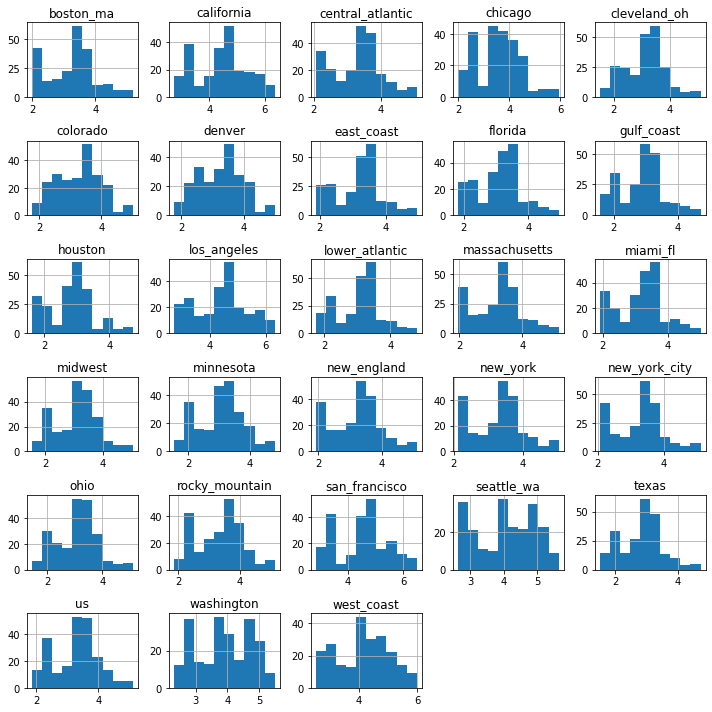

In [ ]:
dfn.hist(bins=10, figsize=(10, 10));
plt.tight_layout()


## 3.0. Feature Engineering


### 3.1. Future Datafarme for Feature Engineering


For feature engineering is necessary a long dataframe with (date, key, y) and "consistency weeks", we can do a resampling for monthly data or work with weekly data too.

I will create the future dataframe for compute all necessary features just one time for train, test, valid, cv and future forecasting, because is necessary all available features for future forcasting and for CV time blocks.

The business problem is about forecasting the next 4 months of gas price, if today is 2021-01-01, the forecast of gas price is for today up to 2021-04-01, for this study case i will select series >= 2020 for this development cycle, 2020 fully for train and in 2021 and a forecast interval of 4 months for CV and one month with gap, traditional "prequential window".

In [ ]:
df3 = df2_long.copy()
df3 = df3.set_index("date").groupby("region").resample("W").sum().reset_index()
df3 = df3.sort_values(["date", "region"]).reset_index(drop=2)

df3["future"] = False

In [ ]:
dt_range = pd.date_range(
    df3["date"].max(),
    df3["date"].max() + pd.DateOffset(months=4),
    freq="W"
)[1:].to_list()

dff = pd.DataFrame([{"region": region, "date": dt_range} for region in df3.region.unique()]).explode("date").sort_values(["date", "region"]).reset_index(drop=2)
dff["price"] = np.nan
dff["future"] = True

df3 = pd.concat([df3, dff]).reset_index(drop=True)
f = (df3["future"] == True)

In [ ]:
df3

region 
 date 
 price 
 future 
 
 
 
 
 0 
 boston_ma 
 1993-04-11 
 0.000 
 False 
 
 
 1 
 california 
 1993-04-11 
 0.000 
 False 
 
 
 2 
 central_atlantic 
 1993-04-11 
 1.068 
 False 
 
 
 3 
 chicago 
 1993-04-11 
 0.000 
 False 
 
 
 4 
 cleveland_oh 
 1993-04-11 
 0.000 
 False 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 45915 
 seattle_wa 
 2024-09-08 
 NaN 
 True 
 
 
 45916 
 texas 
 2024-09-08 
 NaN 
 True 
 
 
 45917 
 us 
 2024-09-08 
 NaN 
 True 
 
 
 45918 
 washington 
 2024-09-08 
 NaN 
 True 
 
 
 45919 
 west_coast 
 2024-09-08 
 NaN 
 True 
 
 
 
 45920 rows × 4 columns


In time series, we cannot choose random samples for cross-validation because time order is important, it makes sense to use previous data to predict the next *n* samples in a given interval.

The goal is a future point prediction of gas price, time series in general are a single sample of the forecast distribution at time "t", forecasting techniques need to find this random process for forecasting in the future, it is possible to create many forecasts and average the predictions to create a point forecasting.  

The business problem requires an accurate gas price forecast for 4 months. Make sense to slide the price prediction window in a range of 4 months (forecast interval) with a extra "gap" of one month, this technique is called sliding prequential with gap, basically 4 sliding months and one month off.

Why is it important in feature engineering step?

I need all my *feature engineering features* available for forecasting at all intervals (future intervals). If I get NaN, something happened and I need to fix it i cannot have nan variables to future, especially if I need to explain what is happening and know exactly which tools to use for predictions.

In [ ]:
dff = df3[df3["region"] == "ohio"]
dff = dff[dff["date"] >= "2020-01-01"]
dff = dff[~f]

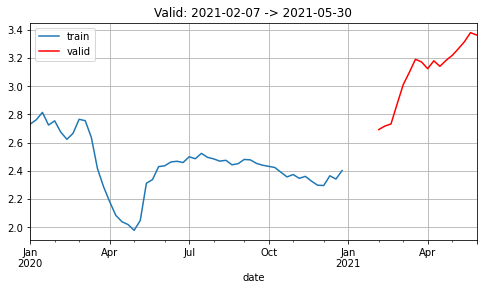

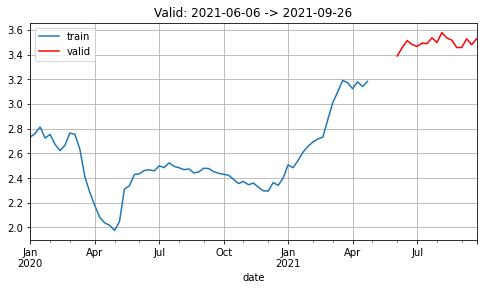

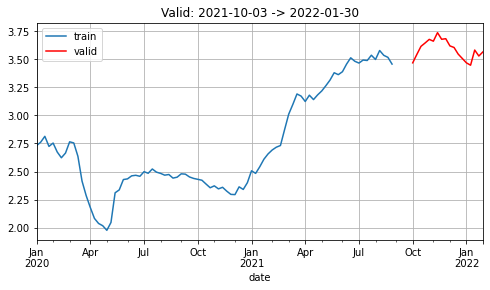

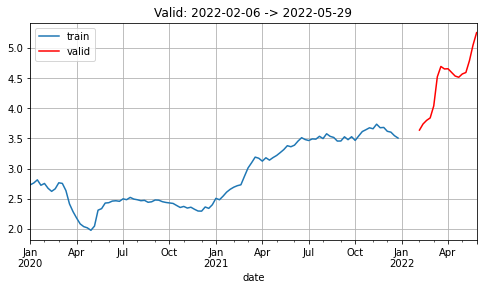

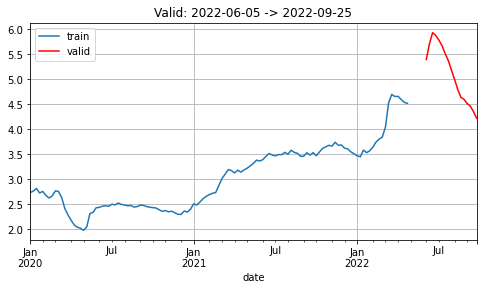

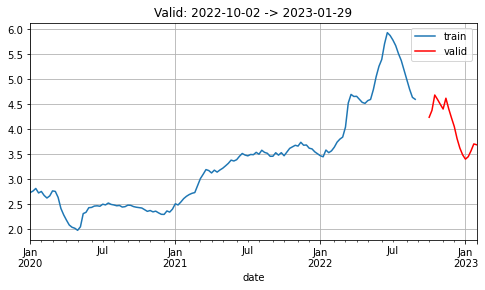

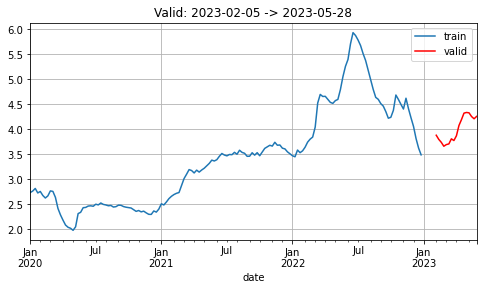

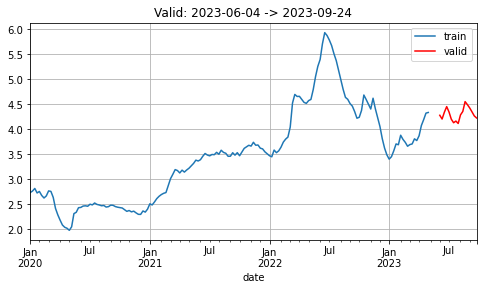

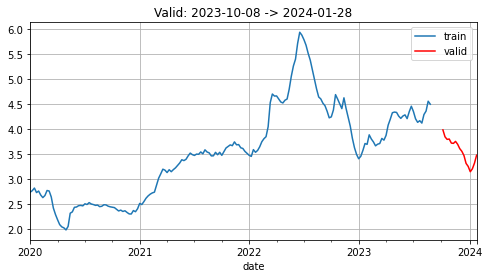

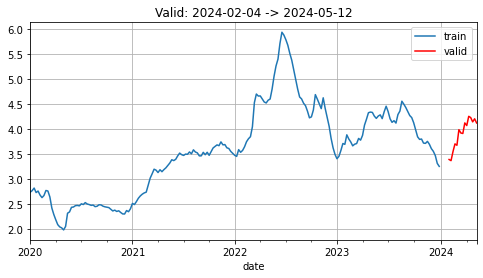

In [ ]:
# Starting Validation date & gap of one month
cutoff_date = datetime(2021, 1, 1)
gap_months = 1

while df3[~f]["date"].max() >= cutoff_date:
    # Training and Valid with one month gap pandas spliting
    start_cutoff_date_gap = (cutoff_date + pd.DateOffset(months=gap_months)).strftime("%Y-%m") + "-01"
    end_cutoff_end_date_gap = (cutoff_date + pd.DateOffset(months=gap_months + 4)).strftime("%Y-%m") + "-01"

    df_train = dff[dff["date"] < cutoff_date.strftime("%Y-%m-%d")]
    df_valid = dff[(dff["date"] > start_cutoff_date_gap) & (dff["date"] < end_cutoff_end_date_gap)]

    # if do not have data, than break
    if df_valid.empty: break

    ax = df_train.plot(x="date", y="price", label="train", figsize=(8, 4))
    df_valid.plot(x="date", y="price", color="r", ax=ax, label="valid", grid=2)
    ax.set_title(f"Valid: {df_valid['date'].min().strftime('%Y-%m-%d')} -> {df_valid['date'].max().strftime('%Y-%m-%d')}");

    cutoff_date += pd.DateOffset(months=4)


### 3.2. Mind Map & Hypothesis List


![mind_map](https://raw.githubusercontent.com/xGabrielR/Gas-Price-Forecast/main/imgs/mind_map.png)

Simple Questions to answer.

1. The total price of gas increased more then 50% compared to the previous year.
2. The total price of gas increase more than 10% in last two quarters on year.
3. The region Ohio have gas price 2x more expensive than other regions.
4. The last days of months, the gas price have a increase of 5x compared to days of start of month. 
5. Texas have the lowest gas price based on all other countries (plot in map). 


### 3.3. Feature Creation


[x] 1. Date Derivative features;

[x] 2. Time Series Features (Lag, Diff, Acf, Sums...);

[ ] 3. Decomposition Features (Season, Trend, MA, Exponentially Weight...).

[x] 4. Lat Long Features (Rotations, inspections, maps...).

[ ] 5. Other featured derivated from mind map to help price forecasting.

Exists a lot of features to compute in time series, but i will start with more simple fatures.
All features is stored in a Feature Store.


#### 3.3.1. Date Features

In [ ]:
df3["day"] = df3.date.dt.day
df3["year"] = df3.date.dt.year
df3["month"] = df3.date.dt.month
df3["quarter"] = df3.date.dt.quarter
df3["week"] = df3.date.dt.isocalendar()["week"]


#### 3.3.2. Time Series Features


The future forecast is for the next 4 months, is necessary 4 months lag and greather for creating lag features for forecasting interval. If I choose to work with lag months 3, I can only forecast in future for only next 3 months (other months datafarme will get NaN). 

In [ ]:
df3["lag_4_months"] = df3.groupby("region")["price"].shift(17)
df3["lag_5_months"] = df3.groupby("region")["price"].shift(22)
df3["lag_12_months_plus"] = df3.groupby("region")["price"].shift(53)
df3["lag_12_months"] = df3.groupby("region")["price"].shift(52)
df3["lag_12_months_minus"] = df3.groupby("region")["price"].shift(51)

df3["diff_4_months"] = df3.groupby("region")["price"].shift(17).diff(17)
df3["diff_5_months"] = df3.groupby("region")["price"].shift(22).diff(22)
df3["diff_12_months_plus"] = df3.groupby("region")["price"].shift(53).diff(53)
df3["diff_12_months"] = df3.groupby("region")["price"].shift(52).diff(52)
df3["diff_12_months_minus"] = df3.groupby("region")["price"].shift(51).diff(51)


#### 3.3.3. Lat Long Features


For this type of feature is necessary to create on Bronze -> Silver cleaning or in a feature store notebook ingestion, not in exploratory notebook.

In [ ]:
df3["latitude"] = np.nan
df3["longitude"] = np.nan

In [ ]:
for region in df3.region.unique()[20:]:
    if region == "lower_atlantic":
        query = "south carolina us"
    elif region == "ohio":
        query = "ohio"
    else:
        query = f"us - {region}"

    geo = agent.geocode(query)
    df3.loc[df3["region"] == region, "latitude"] = geo.latitude
    df3.loc[df3["region"] == region, "longitude"] = geo.longitude

    sleep(5)


#### 3.3.4. Databricks Feature Store


Full history with all features on a delta feature store.

In [ ]:
spark.createDataFrame(df3).coalesce(1).write.format("delta").save("/mnt/delta/gas_price_features")

In [ ]:
# Save Features into to Feature Storage
fs = feature_store.FeatureStoreClient()

df_spark = spark.createDataFrame(df3)

fs.create_table(
    name="gas_price_raw_features",
    description="Raw Gas Price Forecast Features",
    df=df_spark,
    schema=df_spark.schema,
    primary_keys=["date", "region"]
)


## 4.0. Data Filtering


With all features created and stored, now any data scientist can take this features and the history for other explorations.

Is possible to do a filtering now for my use case and my development without changing any raw data with features stored on a feature store.

Now, I will filter the dataset for exploration and machine learning, in time series is impossible to do feature engineering on reduced dataset, because you can lost lag, diff and weight features values.

In [ ]:
df4 = df3.copy()

df4 = df4[df4["date"] >= "2020-01-01"]


## 5.0. Exploratory Data Analysis


### 5.1. Univariate Analysis

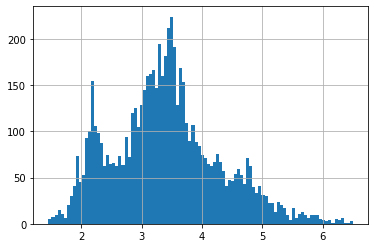

In [ ]:
df4["price"].hist(bins=100);

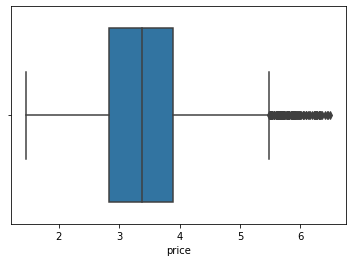

In [ ]:
sns.boxplot(df4["price"]);

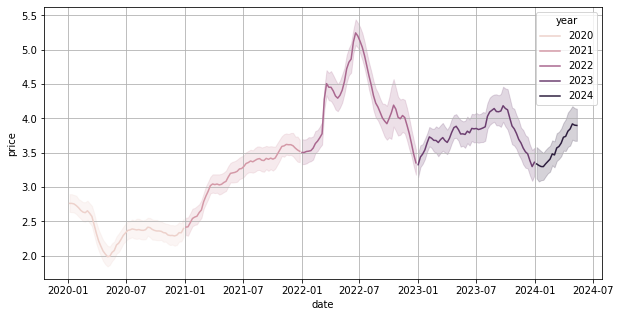

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df4, x="date", y="price", hue="year", ax=ax)
ax.grid(2);

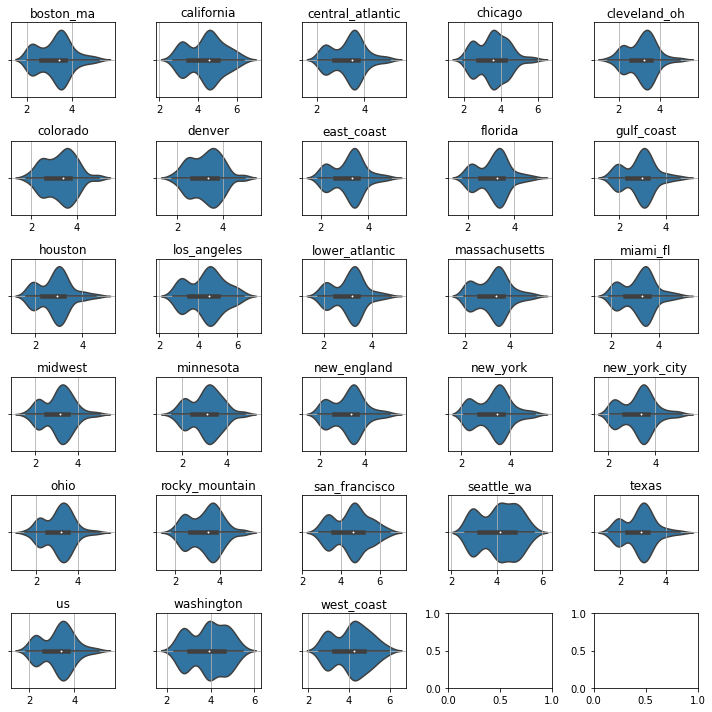

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))
ax = ax.flatten()

regions = dff.region.unique()
regions.sort()

for axi, region in zip(ax, regions):
    sns.violinplot(dff.loc[dff.region == region, "price"].values, ax=axi)
    axi.grid(2)
    axi.set_title(region)

plt.tight_layout()

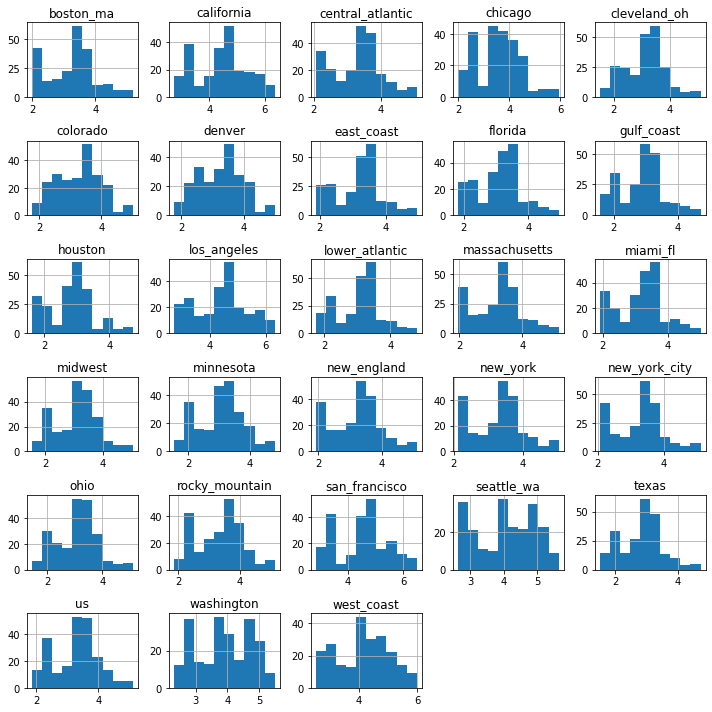

In [ ]:
df4.pivot(index="date", values="price", columns="region").hist(bins=10, figsize=(10, 10));
plt.tight_layout();


### 5.2. Bivariate Analysis


#### 5.2.1. Seasonal Plots

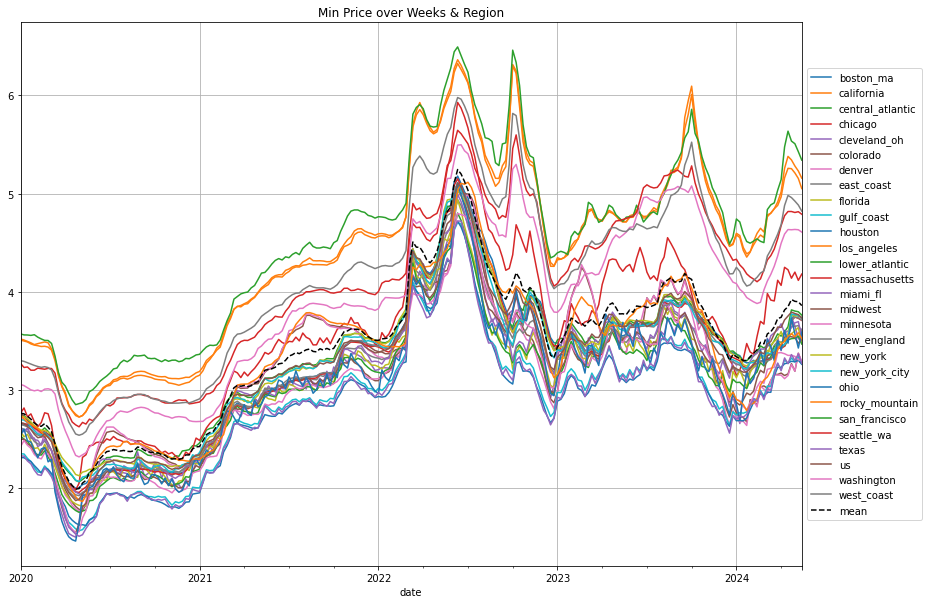

In [ ]:
plot_multiple_single_series(df4)

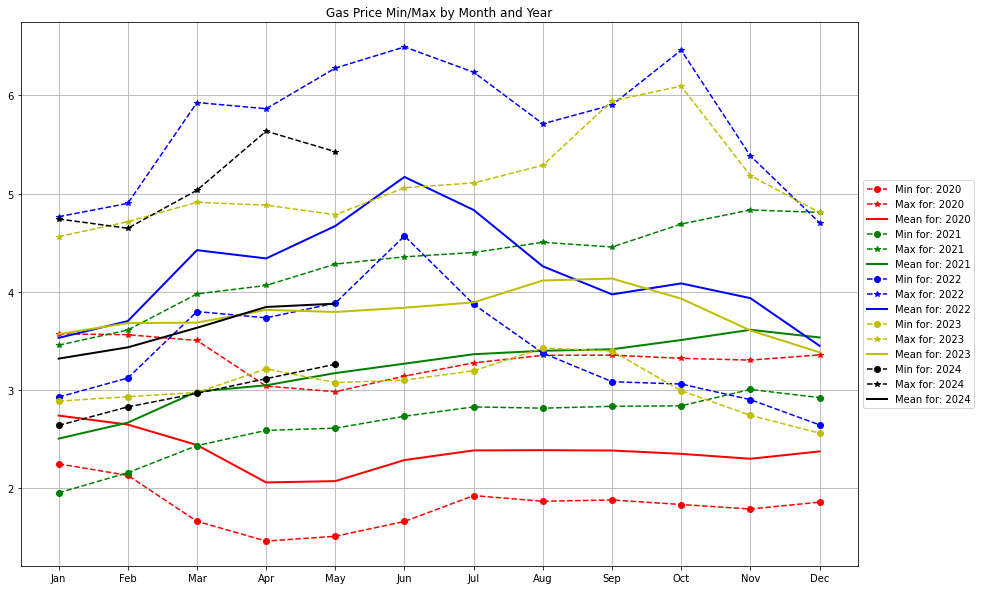

In [ ]:
plot_min_max_multiple_series(df4)

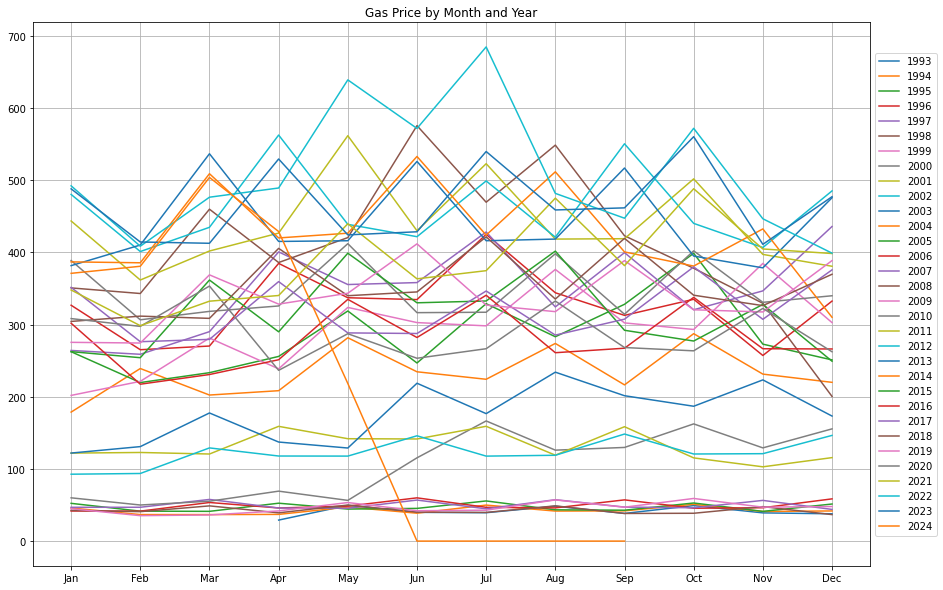

In [ ]:
plot_seasons_year_month(df3)

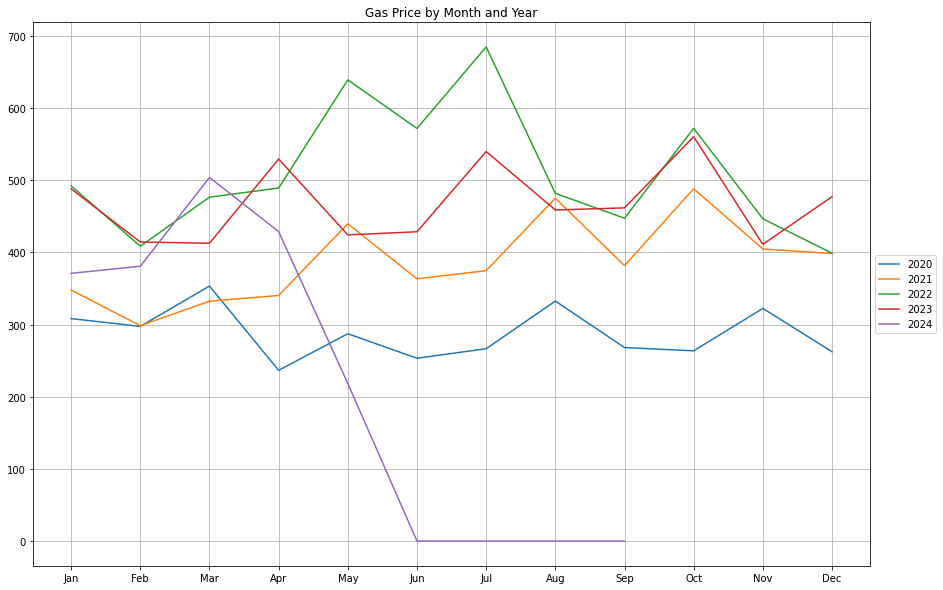

In [ ]:
plot_seasons_year_month(df4)

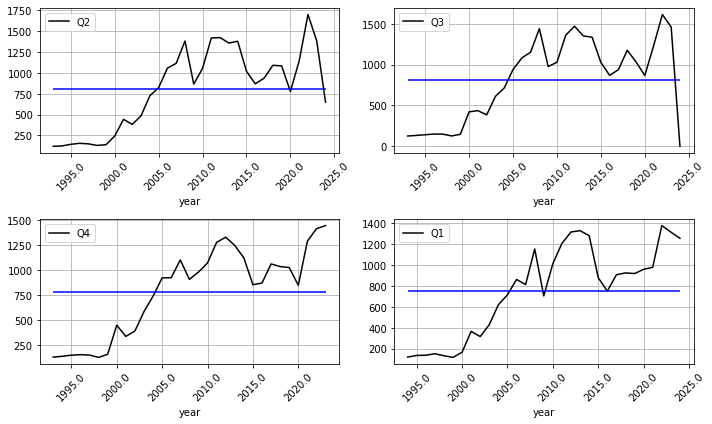

In [ ]:
plot_seasons_quarter_month(df3)

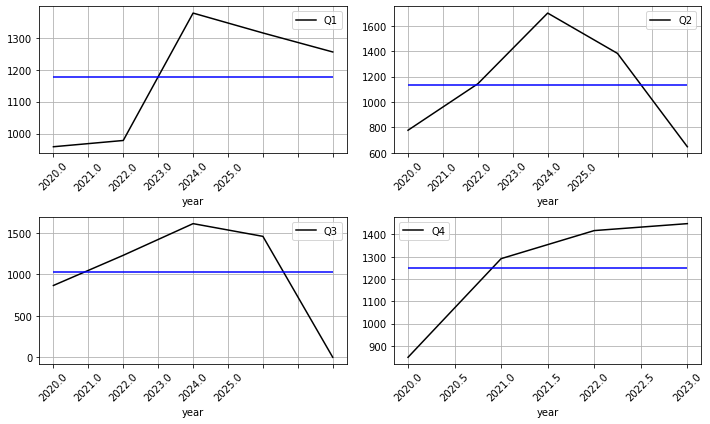

In [ ]:
plot_seasons_quarter_month(df4)


#### 5.2.2. Hypothesis Plots


##### **The total price of gas increased more then 50% compared to the previous year.**

False

price 
 
 
 year 
 
 
 
 
 
 2022 
 4.195146 
 
 
 2023 
 3.777522 
 
 
 2024 
 3.576695 
 
 
 2021 
 3.189953 
 
 
 2020 
 2.370723

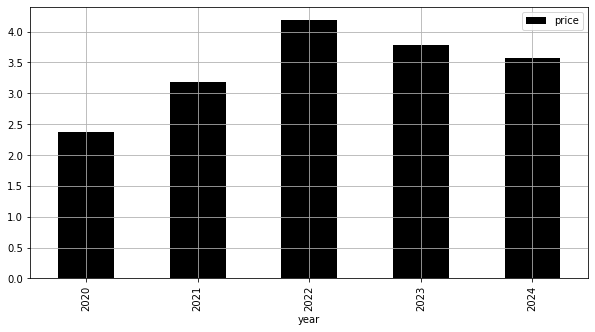

In [ ]:
mean_prices = df4[["price", "year"]].groupby("year").mean()

mean_prices.plot(
  kind="bar",
  color="k",
  figsize=(10,5),
  grid=2
);

mean_prices.sort_values(by="price", ascending=False).head()


##### **The total price of gas increase more than 10% in last two quarters on year.**

False

price 
 
 
 quarter 
 
 
 
 
 
 3 
 2.272807 
 
 
 2 
 2.253568 
 
 
 4 
 2.120300 
 
 
 1 
 2.084511

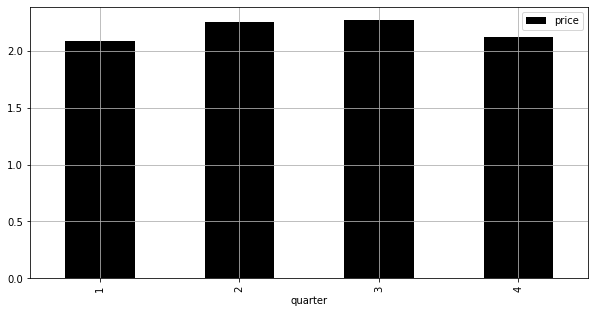

In [ ]:
mean_prices = df3[["price", "quarter"]].groupby("quarter").mean()

mean_prices.plot(
  kind="bar",
  color="k",
  figsize=(10,5),
  grid=2
);

mean_prices.sort_values(by="price", ascending=False).head()


##### **The region Ohio have gas price 2x more expensive than other regions.**

False

           region     price
22  san_francisco  1029.525
1      california  1005.848
11    los_angeles  1002.867
27     west_coast   941.271
23     seattle_wa   928.695


region 
 price 
 
 
 
 
 16 
 minnesota 
 695.852 
 
 
 12 
 lower_atlantic 
 695.589 
 
 
 9 
 gulf_coast 
 656.029 
 
 
 24 
 texas 
 649.009 
 
 
 10 
 houston 
 647.829

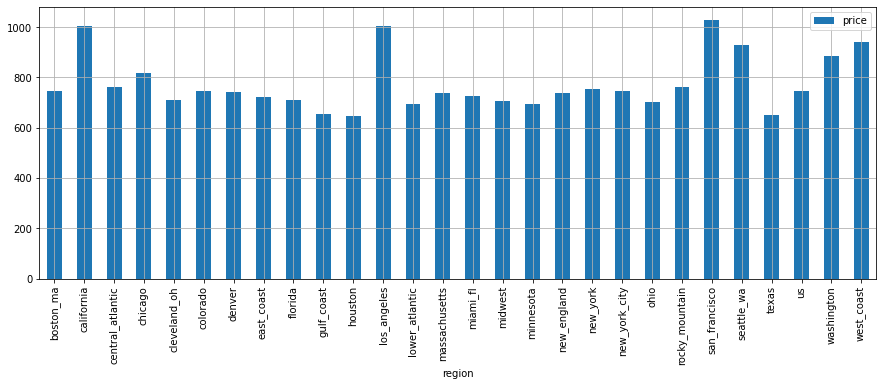

In [ ]:
df3p = df4[["region", "price"]].groupby("region").sum().reset_index()

df3p.plot(
    kind="bar",
    x="region",
    y="price",
    figsize=(15,5),
    grid=2
)

plt.xticks(rotation=90);

print(df3p.sort_values(by="price", ascending=False).head(5))

df3p.sort_values(by="price", ascending=False).tail(5)

              region     price
27        west_coast  4367.035
22     san_francisco  4111.461
11       los_angeles  4054.497
1         california  4044.943
2   central_atlantic  3904.667


region 
 price 
 
 
 
 
 24 
 texas 
 3118.408 
 
 
 10 
 houston 
 3106.966 
 
 
 8 
 florida 
 3098.240 
 
 
 4 
 cleveland_oh 
 3065.558 
 
 
 20 
 ohio 
 3041.248

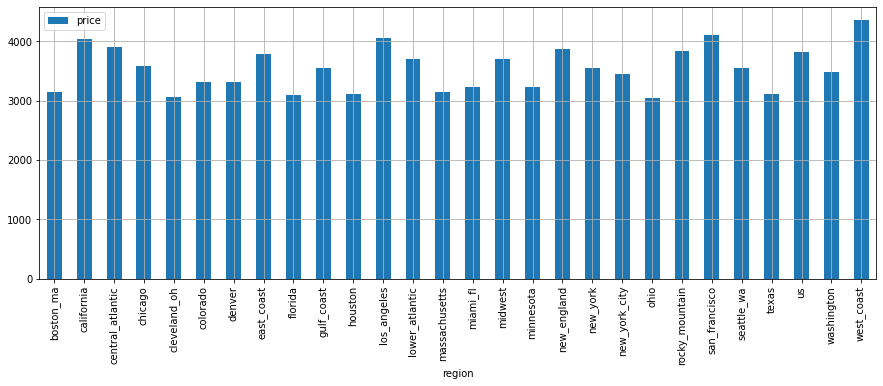

In [ ]:
df3p = df3[["region", "price"]].groupby("region").sum().reset_index()

df3p.plot(
    kind="bar",
    x="region",
    y="price",
    figsize=(15,5),
    grid=2
)

plt.xticks(rotation=90);

print(df3p.sort_values(by="price", ascending=False).head(5))

df3p.sort_values(by="price", ascending=False).tail(5)


##### **The last days of months, the gas price have a increase of 5x compared to days of start of month.**

False

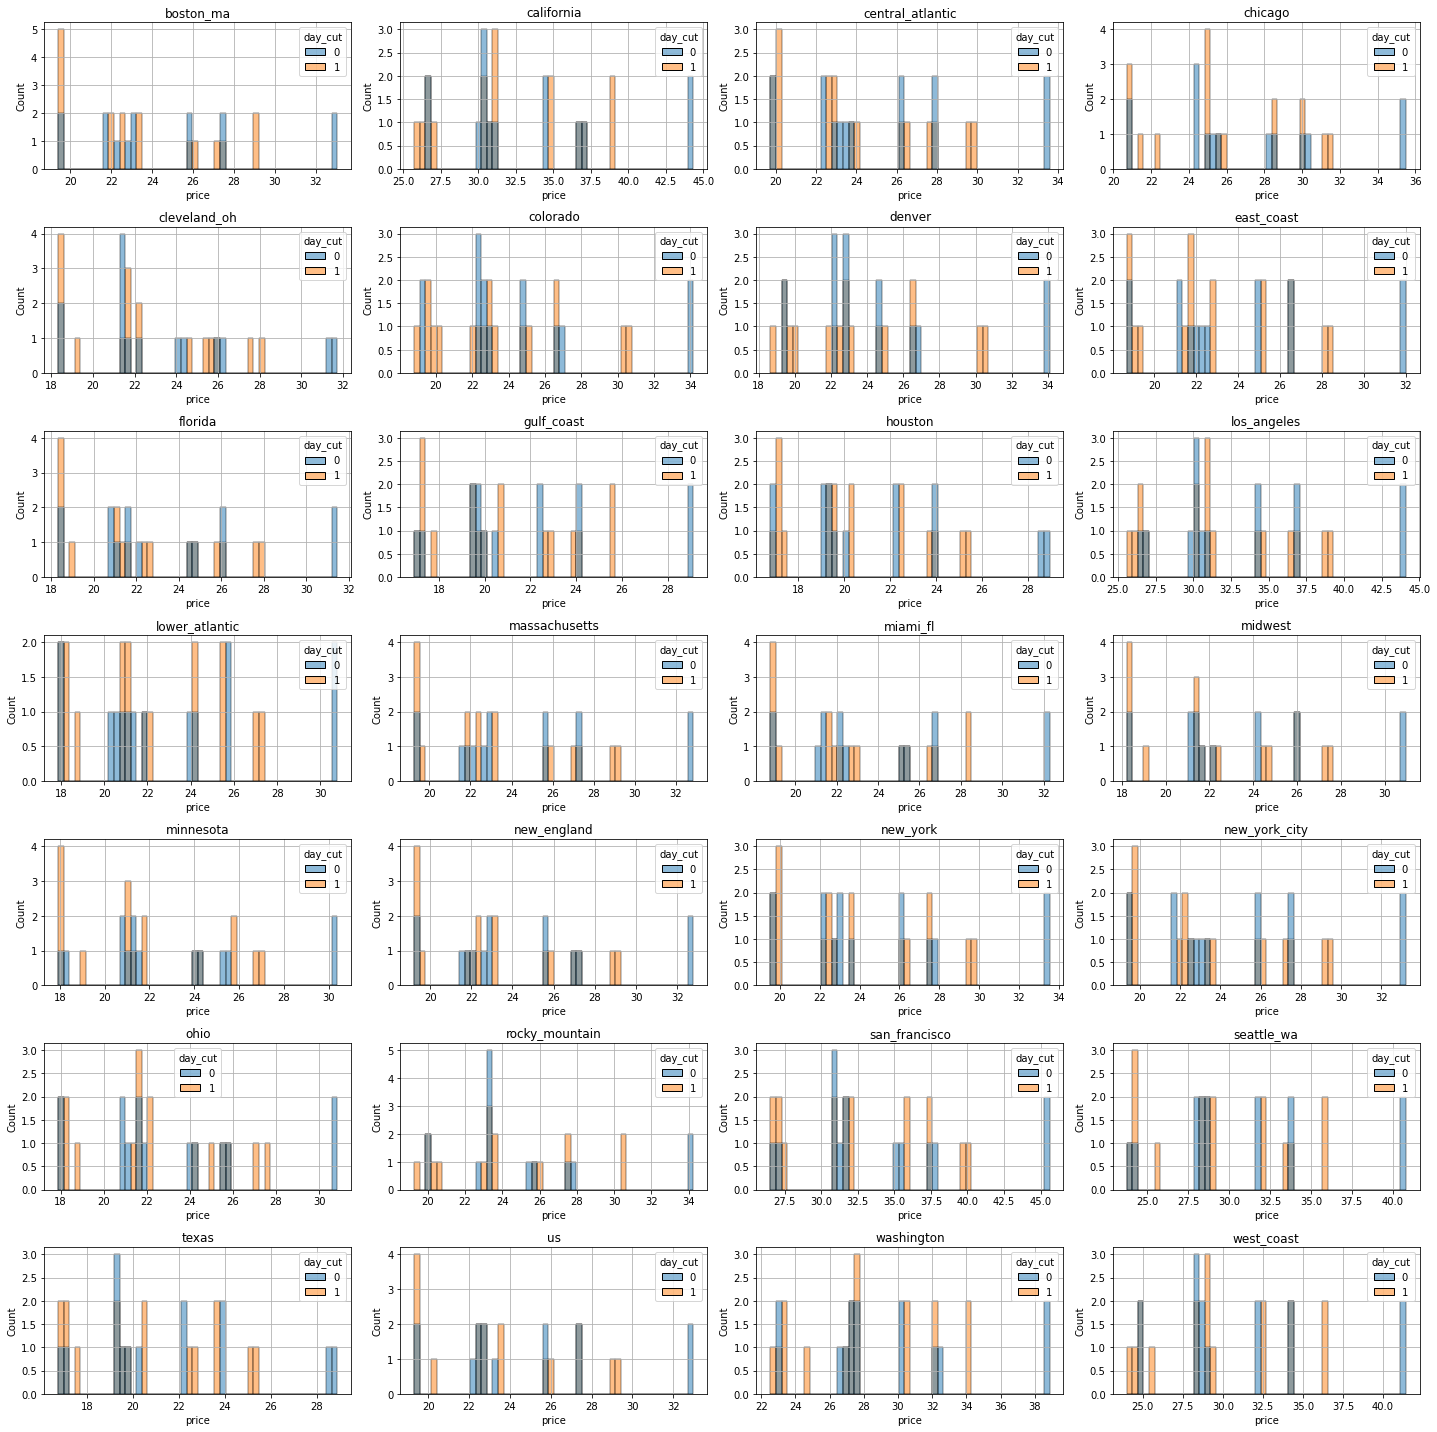

In [ ]:
df3p = df4[["region", "day", "price"]].groupby(["day", "region"]).sum().reset_index()
df3p["day_cut"] = df3p["day"].apply(lambda x: 1 if x >= 15 else 0)

fig, ax = plt.subplots(7, 4, figsize=(20,20))
ax = ax.flatten()

for region, axi in zip(df3p.region.unique(), ax):
    data = df3p[df3p.region == region]

    sns.histplot(
        data=data,
        x="price",
        hue="day_cut",
        ax=axi,
        bins=50
    )

    axi.set_title(region)
    axi.grid(2);

plt.tight_layout()


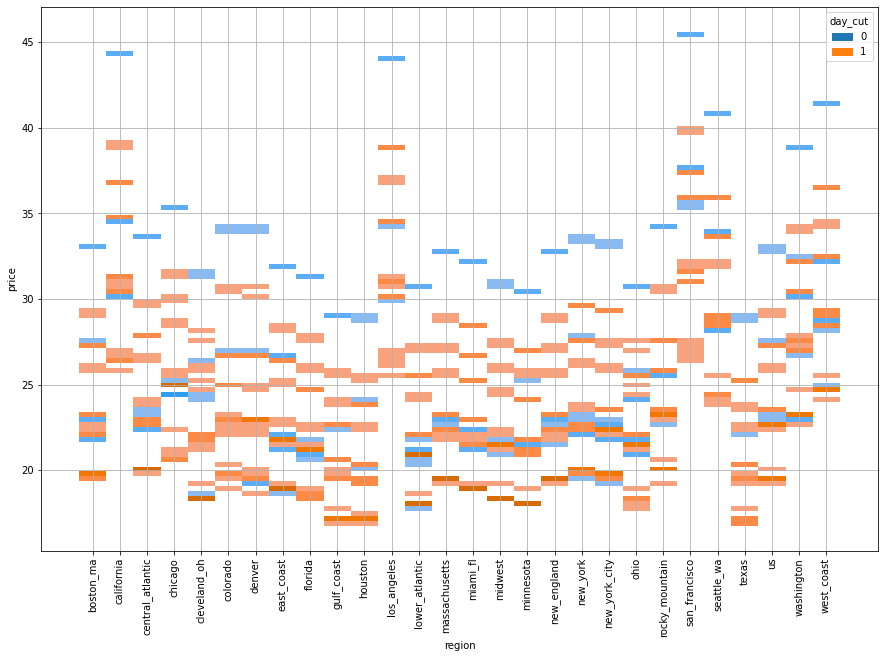

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(2)
sns.histplot(df3p, x="region", y="price", hue="day_cut", bins=100)
plt.xticks(rotation=90);


**Texas have the lowest gas price based on all other countries (plot in map).**

False

In [ ]:
df_lat_long_price = df4[["latitude", "longitude", "region", "price"]].groupby(["latitude", "longitude", "region"]).sum().reset_index()

df_lat_long_price.sort_values(by="price")

latitude 
 longitude 
 region 
 price 
 
 
 
 
 3 
 29.758938 
 -95.367697 
 houston 
 647.829 
 
 
 4 
 31.263890 
 -98.545612 
 texas 
 649.009 
 
 
 1 
 26.301135 
 -81.797742 
 gulf_coast 
 656.029 
 
 
 5 
 33.687439 
 -80.436374 
 lower_atlantic 
 695.589 
 
 
 25 
 45.989659 
 -94.611329 
 minnesota 
 695.852 
 
 
 13 
 40.225357 
 -82.688140 
 ohio 
 702.342 
 
 
 23 
 43.411391 
 -106.280075 
 midwest 
 705.911 
 
 
 2 
 27.756767 
 -81.463983 
 florida 
 709.189 
 
 
 18 
 41.539417 
 -81.635238 
 cleveland_oh 
 711.190 
 
 
 17 
 41.380611 
 -74.312665 
 east_coast 
 723.203 
 
 
 0 
 25.940876 
 -80.248586 
 miami_fl 
 725.963 
 
 
 24 
 44.205708 
 -70.753784 
 new_england 
 739.039 
 
 
 22 
 42.378877 
 -72.032366 
 massachusetts 
 739.803 
 
 
 11 
 39.739236 
 -104.984862 
 denver 
 741.757 
 
 
 9 
 38.725178 
 -105.607716 
 colorado 
 744.351 
 
 
 21 
 42.367970 
 -71.052616 
 boston_ma 
 744.459 
 
 
 12 
 39.783730 
 -100.445882 
 us 
 747.243 
 
 
 15 
 40.712728 
 -74.006015 
 new_york_city 
 747.353 
 
 
 14 
 40.712728 
 -74.006015 
 new_york 
 754.056 
 
 
 26 
 47.590493 
 -122.324313 
 central_atlantic 
 760.147 
 
 
 20 
 41.972870 
 -74.372651 
 rocky_mountain 
 762.160 
 
 
 19 
 41.875562 
 -87.624421 
 chicago 
 815.648 
 
 
 10 
 38.895037 
 -77.036543 
 washington 
 886.792 
 
 
 27 
 47.622137 
 -122.330131 
 seattle_wa 
 928.695 
 
 
 16 
 41.379707 
 -74.312051 
 west_coast 
 941.271 
 
 
 6 
 34.053691 
 -118.242766 
 los_angeles 
 1002.867 
 
 
 7 
 36.701463 
 -118.755997 
 california 
 1005.848 
 
 
 8 
 37.779259 
 -122.419329 
 san_francisco 
 1029.525

In [ ]:
fig = go.Figure(
    data=go.Scattergeo(
        lon=df_lat_long_price["longitude"],
        lat=df_lat_long_price["latitude"],
        text=df_lat_long_price["region"] + " - " + df_lat_long_price["price"].astype(str),
        marker=dict(
            size=df_lat_long_price["price"] / 50,
            color=df_lat_long_price["price"],
            colorscale="Viridis",
            colorbar=dict(title="Price")
        )
    )
)

fig.update_layout(title="Us Gas Price Scatter", geo_scope='usa')
fig.show()


### 5.3. Multivariate Analysis

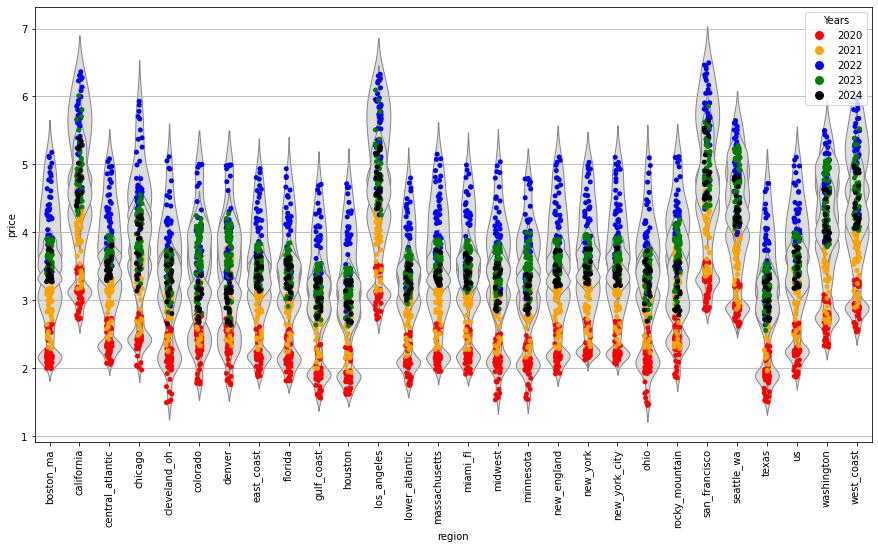

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.grid(2)
legend = []

for year, color in zip(df4.year.unique(), ["red", "orange", "blue", "green", "black"]):
    data = df4[df4["year"] == year]

    sns.violinplot(
        data=data,
        x="region",
        y="price",
        ax=ax,
        scale='width',
        inner=None,
        linewidth=1,
        color='#DDDDDD',
        saturation=1
    )

    axi = sns.stripplot(
        data=data,
        x="region",
        y="price",
        color=color,
        jitter=True,
        linewidth=0.01,
    )

    legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=str(year)))

# Display the legend with the proxy artists
ax.legend(handles=legend, title="Years", loc="upper right")

plt.xticks(rotation=90);

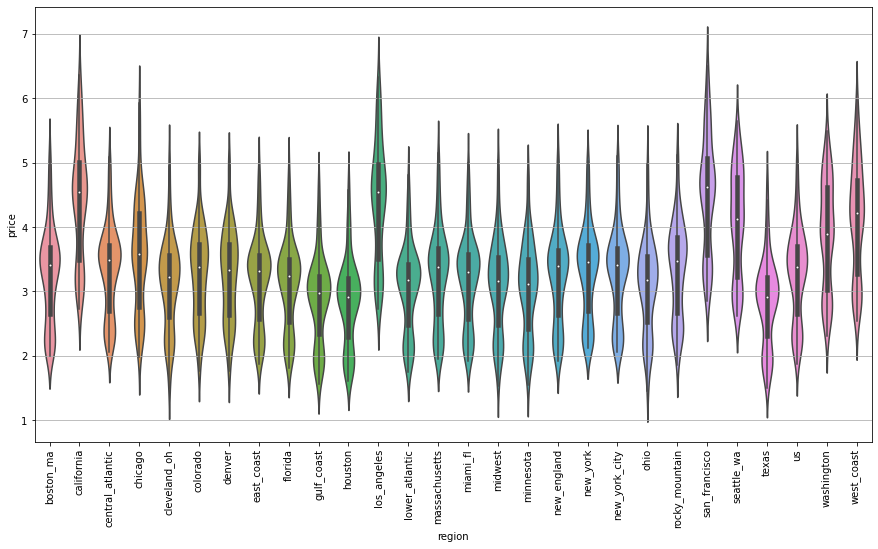

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.grid(2)
sns.violinplot(data=df4, x="region", y="price")
plt.xticks(rotation=90);

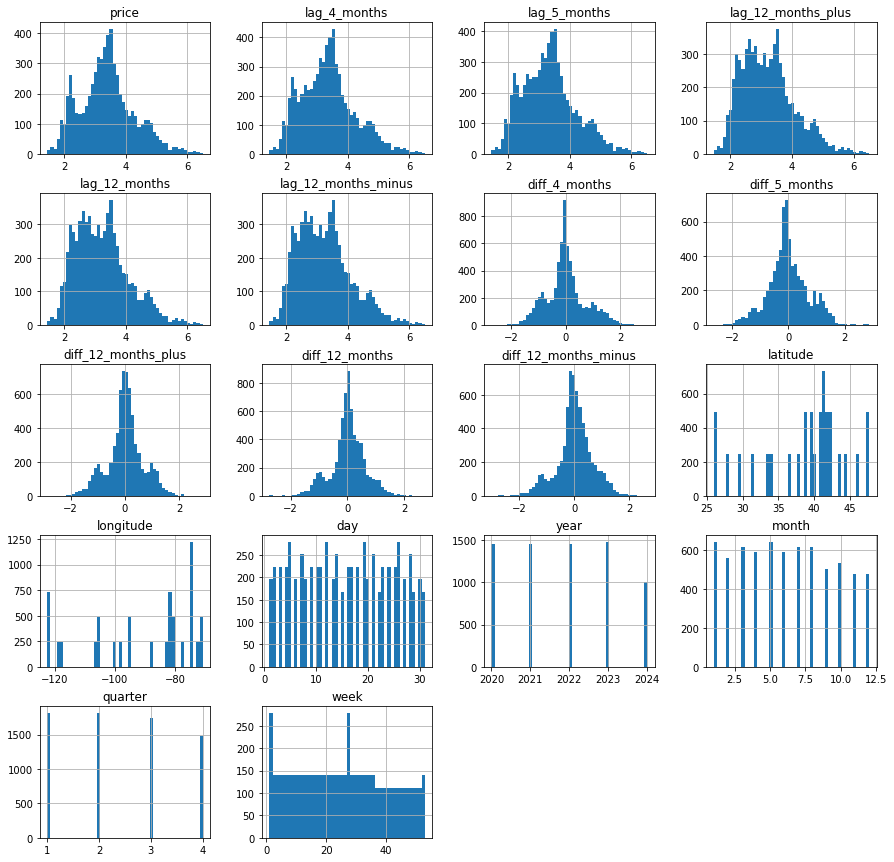

In [ ]:
df4.iloc[:, 2:].hist(
    bins=50, figsize=(15,15)
);

Linear correlated data engineering features. 

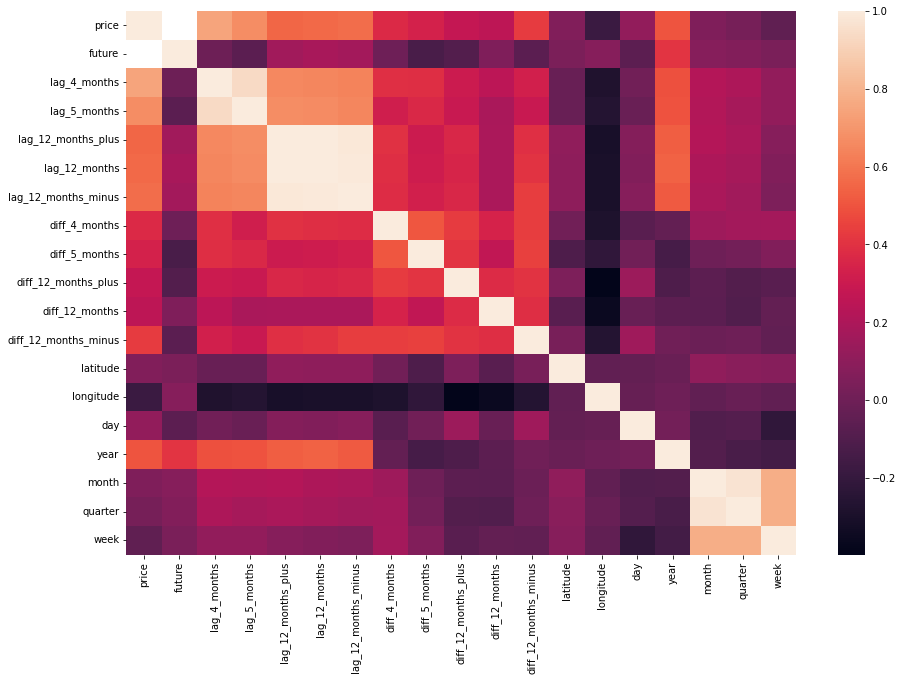

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df4.iloc[:, 2:].sample(100).corr(method="pearson"));

Linear correlation between regions.

In [ ]:
corrs = df2.corr(method="pearson")

Out[613]: <seaborn.axisgrid.PairGrid at 0x7ff3eba60fd0>

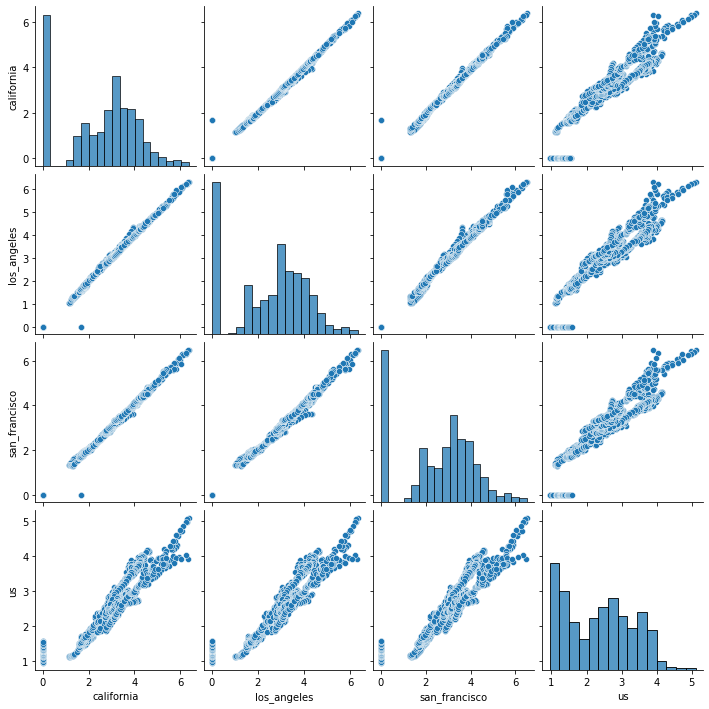

In [ ]:
sns.pairplot(df2[corrs[corrs.apply(lambda x: x < 0.95)].iloc[:, [0]].dropna().index.tolist() + ["us"]])